In [1]:
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [13]:
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair

class MyGabor(_ConvNd):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        
        super(MyGabor, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation,False, _pair(0), groups, bias)
        
        # TODO: подумать над инициализацией параметров
        self.sigma_x = nn.Parameter(0.5*torch.rand(out_channels, in_channels))
        self.sigma_y = nn.Parameter(0.5*torch.rand(out_channels, in_channels))
        self.freq = nn.Parameter((kernel_size[0]/2)*torch.rand(out_channels, in_channels))
        self.theta = nn.Parameter(3.14*torch.rand(out_channels, in_channels))
        self.psi = nn.Parameter(6.28*torch.rand(out_channels, in_channels))
        #self.evaluate = False
    
    #def eval(self):
        #self.evaluate = True
        
    #def train(self):
        #self.evaluate = False
        
    def forward(self, input):
        
        '''if self.evaluate == True:
            return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)'''
        
        y, x = torch.meshgrid([torch.linspace(-0.5,0.5,self.kernel_size[0]), torch.linspace(-0.5,0.5,self.kernel_size[1])])
        x = x.to(device)
        y = y.to(device)
        weight = torch.empty(self.weight.shape, requires_grad=False).to(device)
        for i in range(self.out_channels):
            for j in range(self.in_channels):
                sigma_x = self.sigma_x[i,j].expand_as(y)
                sigma_y = self.sigma_y[i,j].expand_as(y)
                freq = self.freq[i,j].expand_as(y)
                theta = self.theta[i,j].expand_as(y)
                psi = self.psi[i,j].expand_as(y)
                
                rotx = x * torch.cos(theta) + y * torch.sin(theta)
                roty = -x * torch.sin(theta) + y * torch.cos(theta) 
                g = torch.zeros(y.shape)
                g = torch.exp(-0.5 * (rotx ** 2 / (sigma_x + 1e-3) ** 2 + roty ** 2 / (sigma_y + 1e-3) ** 2))
                g = g * torch.cos(2 * 3.14 * freq * rotx + psi) #/ (2*3.14*sigma_x*sigma_y + 1e-3)
                weight[i,j] = g
                self.weight.data[i,j] = g    
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [109]:
import torch
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.utils import _pair

class MyGaborCurved(_ConvNd):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        
        super(MyGaborCurved, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation,False, _pair(0), groups, bias)
        
        # TODO: подумать над инициализацией параметров
        self.sigma_x = nn.Parameter(torch.ones(out_channels, in_channels))
        self.sigma_y = nn.Parameter(torch.ones(out_channels, in_channels))
        self.freq = nn.Parameter((kernel_size[0]/2)*torch.ones(out_channels, in_channels))
        self.theta = nn.Parameter(3.14*torch.ones(out_channels, in_channels) + 3.14)
        self.theta2 = nn.Parameter(6.28*torch.ones(out_channels, in_channels) + 3.14)
        self.psi = nn.Parameter(6.28*torch.rand(out_channels, in_channels))
        self.rad = nn.Parameter(1 + torch.rand(out_channels, in_channels))
        self.center_x = nn.Parameter(2*(kernel_size[0]/2)*torch.rand(out_channels, in_channels) - 1)
        self.center_y = nn.Parameter(2*(kernel_size[0]/2)*torch.rand(out_channels, in_channels) - 1)
        #self.evaluate = False
    
    #def eval(self):
        #self.evaluate = True
        
    #def train(self):
        #self.evaluate = False
        
    def forward(self, input):
        
        '''if self.evaluate == True:
            return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)'''
        y, x = torch.meshgrid([torch.linspace(-0.5,0.5,self.kernel_size[0]), torch.linspace(-0.5,0.5,self.kernel_size[1])])
        x = x.to(device)
        y = y.to(device)
        weight = torch.empty(self.weight.shape, requires_grad=False).to(device)
        for i in range(self.out_channels):
            for j in range(self.in_channels):
                sigma_x = self.sigma_x[i,j].expand_as(y)
                sigma_y = self.sigma_y[i,j].expand_as(y)
                freq = self.freq[i,j].expand_as(y)
                theta = self.theta[i,j].expand_as(y)
                psi = self.psi[i,j].expand_as(y)
                cx = (self.center_x[i,j] - self.rad[i,j]*torch.cos(self.theta2[i,j])).expand_as(y)
                cy = (self.center_y[i,j] - self.rad[i,j]*torch.sin(self.theta2[i,j])).expand_as(y)
                r = ((x - cx)**2 + (y - cy)**2)**(1/2)
                rotx = x * torch.cos(theta) + y * torch.sin(theta)
                roty = -x * torch.sin(theta) + y * torch.cos(theta) 
                g = torch.zeros(y.shape)
                g = torch.exp(-0.5 * (rotx ** 2 / (sigma_x + 1e-3) ** 2 + roty ** 2 / (sigma_y + 1e-3) ** 2))
                g = g * torch.cos(2 * 3.14 * freq * r + psi) #/ (2*3.14*sigma_x*sigma_y + 1e-3)
                weight[i,j] = g
                self.weight.data[i,j] = g    
        return F.conv2d(input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [110]:
gc = MyGaborCurved(1,1,(200,200)).to(device)
gc(torch.rand(1,1,1000,1000).to(device))

tensor([[[[ 7.5956e+01,  7.6405e+01,  7.5492e+01,  ..., -1.4246e+01,
           -1.1787e+01, -2.6576e+00],
          [ 7.2390e+01,  7.1416e+01,  6.9080e+01,  ..., -1.1910e+01,
           -9.2869e+00,  6.0313e-02],
          [ 6.8041e+01,  6.5882e+01,  6.2193e+01,  ..., -1.8136e+01,
           -1.4560e+01, -4.0938e+00],
          ...,
          [ 2.4606e+01,  2.9406e+01,  3.1032e+01,  ..., -7.2649e+01,
           -7.1509e+01, -7.1296e+01],
          [ 3.0636e+01,  3.6293e+01,  3.8166e+01,  ..., -6.8568e+01,
           -6.6456e+01, -6.5153e+01],
          [ 3.1665e+01,  3.7510e+01,  3.8855e+01,  ..., -6.5165e+01,
           -6.2594e+01, -6.0784e+01]]]],
       device='cuda:0', grad_fn=<CudnnConvolutionBackward>)

In [111]:
gc.rad

Parameter containing:
tensor([[1.]], device='cuda:0', requires_grad=True)

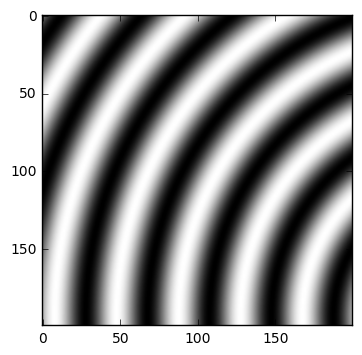

In [112]:
plt.imshow(gc.weight[0][0].to('cpu').detach(), cmap = 'gray')
plt.show()

In [14]:
import os
from random import choice
from PIL import Image
import numpy as np

class DatasetLoader():
    def __init__(self, source_path = 'D:\!EMONEW_cropped', classes = 7, train = 0.66):
        self.source_path = os.path.normpath(source_path)
        self.data = []
        self.test_data = []
        self.num_classes = classes
        self.train = train
        
        for path in os.listdir(path=source_path):
            source_path = os.path.join(self.source_path, path)
            if os.path.isdir(source_path):
                classes = classes - 1
                target = [0]*self.num_classes
                target[classes] = 1
                self._list_to_jpeg(source_path, target)
            
    def _list_to_jpeg(self, path, target):
        for i in os.walk(path):
            for j in i[2]:
                if '.jpg' in j or '.png' in j:
                    if np.random.rand() <= self.train:
                        self.data.append([[os.path.join(i[0], j)], target])
                    else:
                        self.test_data.append([[os.path.join(i[0], j)], target])
    def get_batch(self, len_batch, train = True, keras_style = False):
        batch_data = []
        batch_target = []
        if keras_style:
            transpose = (0,1,2)
        else:
            transpose = (2,0,1)
        
        for i in range(len_batch):
            if train == True:
                d, t = choice(self.data)
            else:
                d, t = choice(self.test_data)
            batch_target.append(t)
            batch_data.append(np.asarray(Image.open(d[0])).transpose(transpose))
        return np.array(batch_data), np.array(batch_target)
    
    def lenght(self, train = True):
        if train == True:
            return len(self.data)
        else:
            return len(self.test_data)

## CHECK DATALOADER

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.g1 = MyGabor(3, 32, kernel_size=(15,15), stride=2)
        self.c1 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=2)
        self.c2 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=2)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = F.relu(self.g1(x))
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = nn.Dropout2d(p = 0.25)(x)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = nn.Dropout2d(p = 0.25)(x)
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = self.fc2(x)
        return x

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = Net().to(device)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
EMONEW = DatasetLoader()

cuda:0
Net(
  (g1): MyGabor(3, 32, kernel_size=(15, 15), stride=(2, 2), bias=False)
  (c1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [17]:
net(torch.rand(1,3,309,287, device=device))

tensor([[-0.5797, -0.0233,  1.3716,  0.3362,  1.3235, -1.1535,  0.6897]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)

theta: 1.29; psi: 2.19; sigmaX: 0.33; sigmaY: 0.34; freq: 4.00;


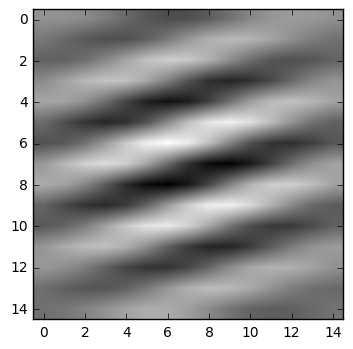

theta: 1.99; psi: 5.34; sigmaX: 0.35; sigmaY: 0.14; freq: 0.42;


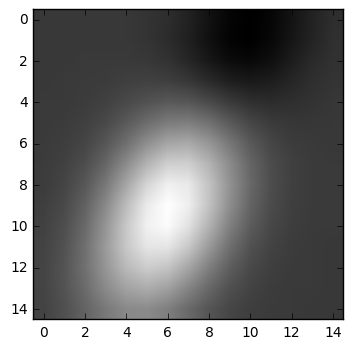

theta: 3.13; psi: 0.06; sigmaX: 0.10; sigmaY: 0.46; freq: 6.00;


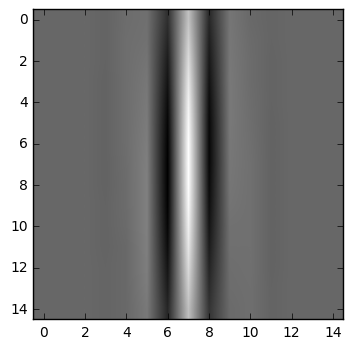

theta: 1.82; psi: 3.74; sigmaX: 0.06; sigmaY: 0.19; freq: 3.58;


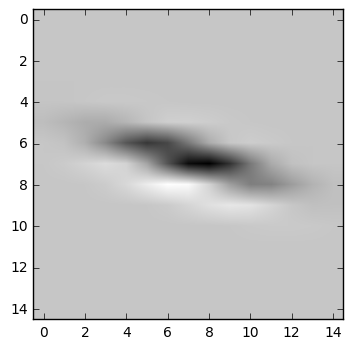

theta: 2.46; psi: 0.37; sigmaX: 0.14; sigmaY: 0.11; freq: 3.03;


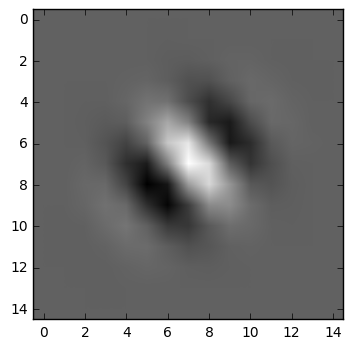

theta: 1.04; psi: 1.26; sigmaX: 0.19; sigmaY: 0.11; freq: 4.86;


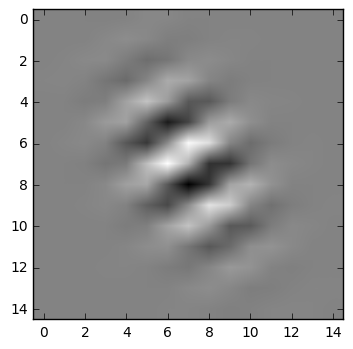

theta: 1.51; psi: 5.12; sigmaX: 0.31; sigmaY: 0.44; freq: 6.03;


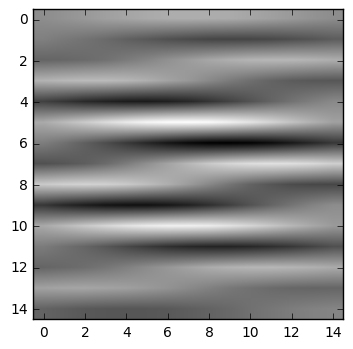

theta: 1.16; psi: 5.11; sigmaX: 0.44; sigmaY: 0.42; freq: 0.63;


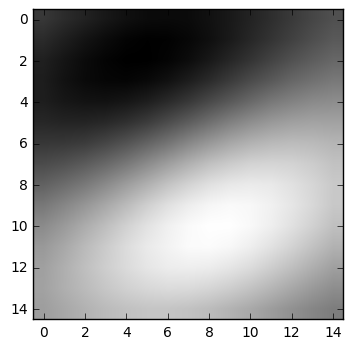

theta: 1.22; psi: 5.59; sigmaX: 0.22; sigmaY: 0.05; freq: 2.35;


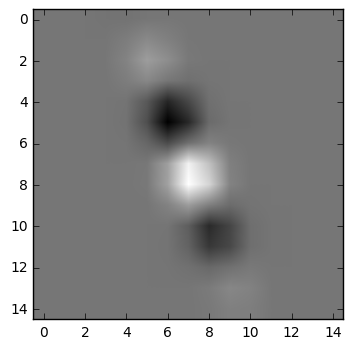

theta: 0.23; psi: 0.93; sigmaX: 0.02; sigmaY: 0.39; freq: 2.23;


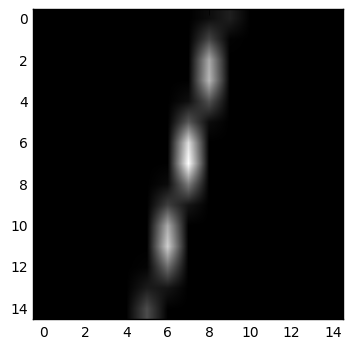

theta: 0.21; psi: 1.59; sigmaX: 0.38; sigmaY: 0.22; freq: 6.69;


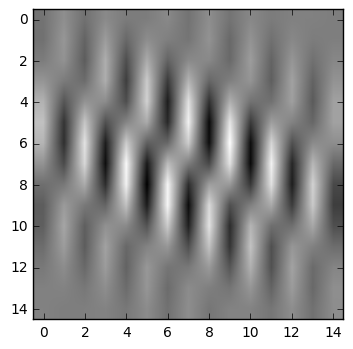

theta: 3.02; psi: 1.69; sigmaX: 0.06; sigmaY: 0.14; freq: 6.26;


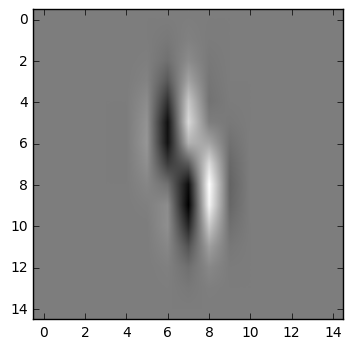

theta: 0.09; psi: 0.50; sigmaX: 0.49; sigmaY: 0.27; freq: 1.76;


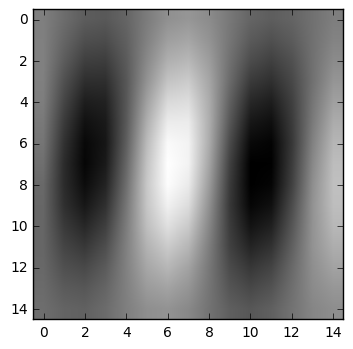

theta: 0.07; psi: 3.34; sigmaX: 0.42; sigmaY: 0.27; freq: 4.67;


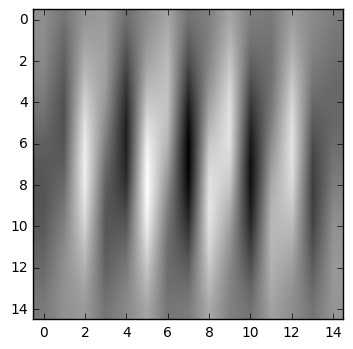

theta: 0.65; psi: 0.22; sigmaX: 0.42; sigmaY: 0.24; freq: 5.85;


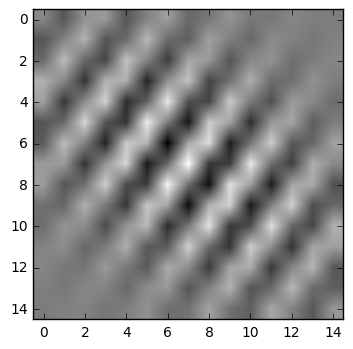

theta: 0.37; psi: 5.99; sigmaX: 0.12; sigmaY: 0.01; freq: 0.66;


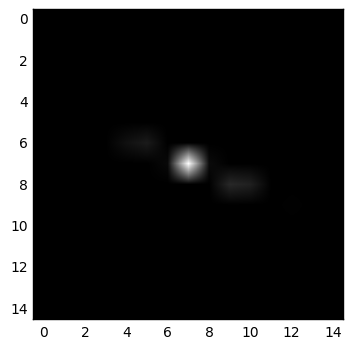

theta: 1.41; psi: 6.13; sigmaX: 0.27; sigmaY: 0.42; freq: 1.26;


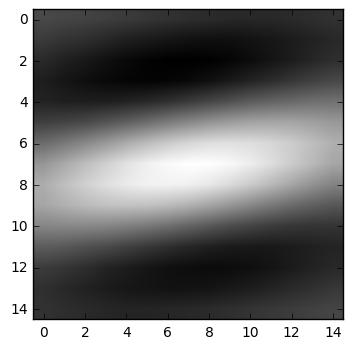

theta: 0.16; psi: 3.38; sigmaX: 0.27; sigmaY: 0.15; freq: 3.12;


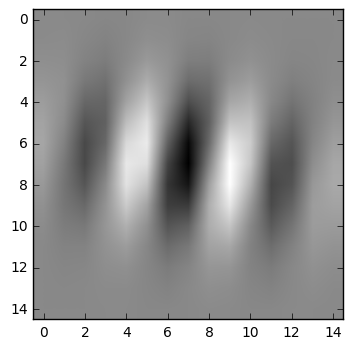

theta: 2.69; psi: 6.17; sigmaX: 0.23; sigmaY: 0.29; freq: 7.31;


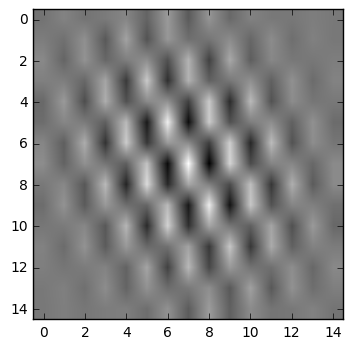

theta: 3.13; psi: 4.95; sigmaX: 0.33; sigmaY: 0.20; freq: 0.90;


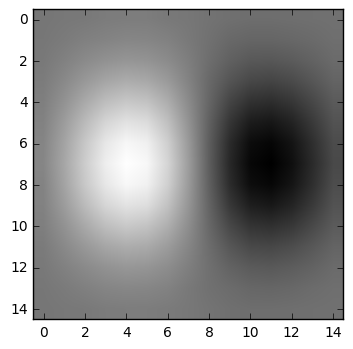

theta: 0.99; psi: 1.74; sigmaX: 0.36; sigmaY: 0.39; freq: 1.04;


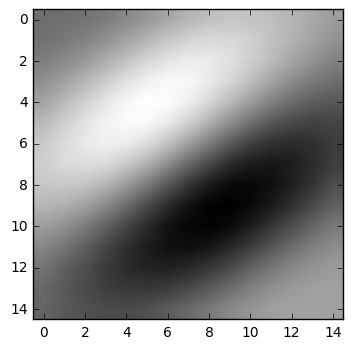

theta: 2.59; psi: 3.86; sigmaX: 0.18; sigmaY: 0.23; freq: 1.72;


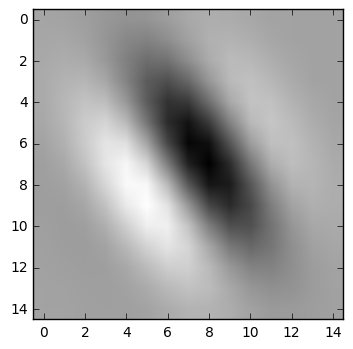

theta: 2.15; psi: 5.94; sigmaX: 0.32; sigmaY: 0.25; freq: 6.14;


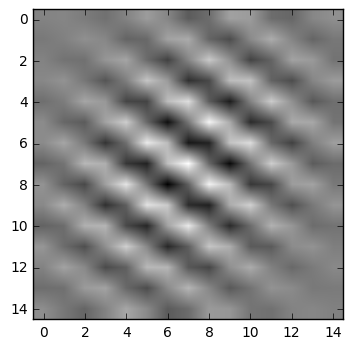

theta: 2.35; psi: 0.68; sigmaX: 0.23; sigmaY: 0.39; freq: 6.24;


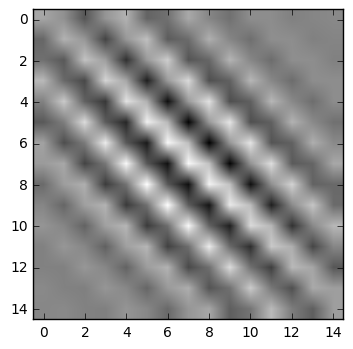

theta: 0.12; psi: 2.03; sigmaX: 0.25; sigmaY: 0.47; freq: 6.47;


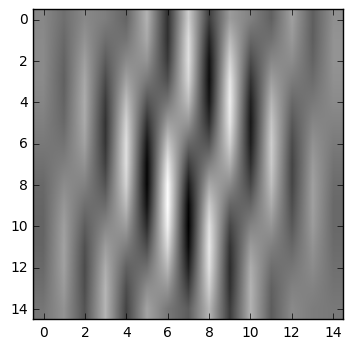

theta: 0.89; psi: 1.96; sigmaX: 0.01; sigmaY: 0.11; freq: 1.20;


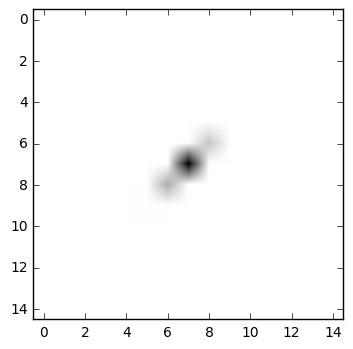

theta: 1.95; psi: 5.43; sigmaX: 0.20; sigmaY: 0.46; freq: 5.89;


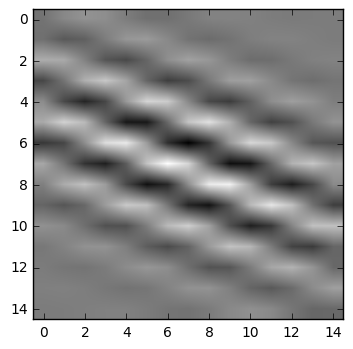

theta: 1.58; psi: 3.90; sigmaX: 0.00; sigmaY: 0.28; freq: 3.96;


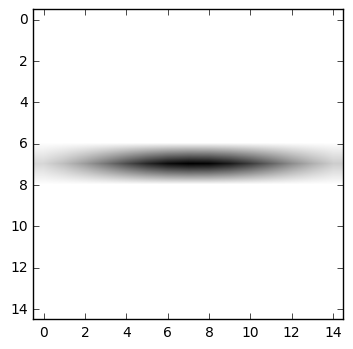

theta: 2.53; psi: 2.85; sigmaX: 0.22; sigmaY: 0.30; freq: 3.84;


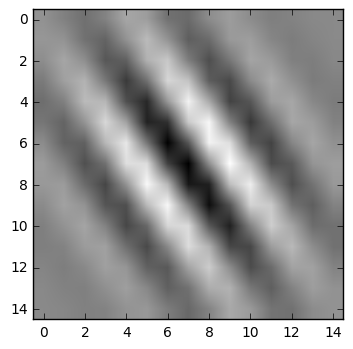

theta: 2.96; psi: 4.07; sigmaX: 0.11; sigmaY: 0.26; freq: 5.54;


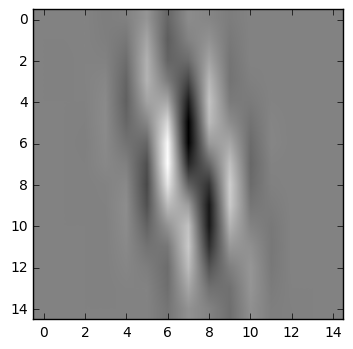

theta: 1.14; psi: 0.31; sigmaX: 0.06; sigmaY: 0.41; freq: 7.38;


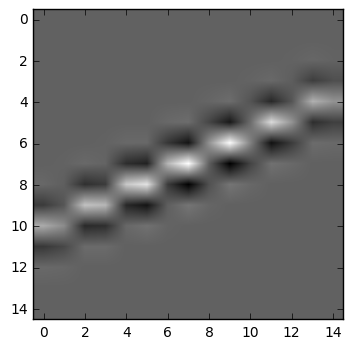

theta: 1.85; psi: 4.24; sigmaX: 0.48; sigmaY: 0.05; freq: 2.06;


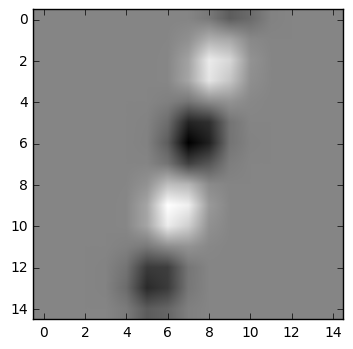

theta: 1.54; psi: 5.79; sigmaX: 0.31; sigmaY: 0.42; freq: 0.44;


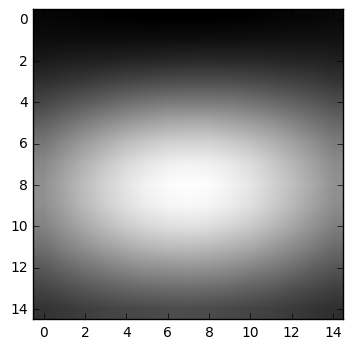

theta: 0.64; psi: 4.64; sigmaX: 0.39; sigmaY: 0.02; freq: 0.76;


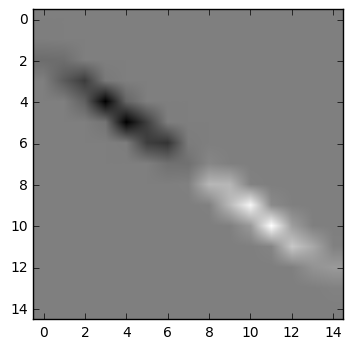

theta: 1.26; psi: 3.99; sigmaX: 0.45; sigmaY: 0.23; freq: 3.67;


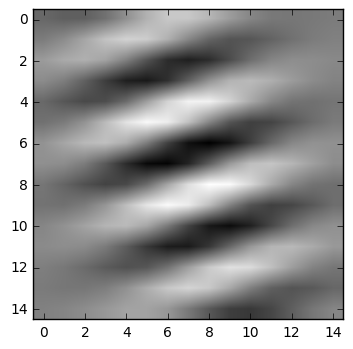

theta: 0.59; psi: 3.47; sigmaX: 0.46; sigmaY: 0.30; freq: 2.89;


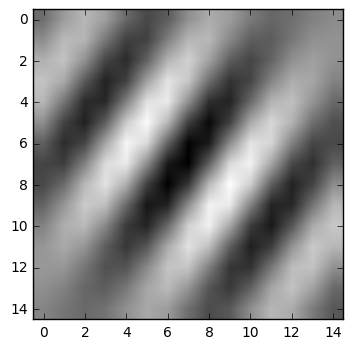

theta: 2.98; psi: 5.38; sigmaX: 0.39; sigmaY: 0.42; freq: 0.19;


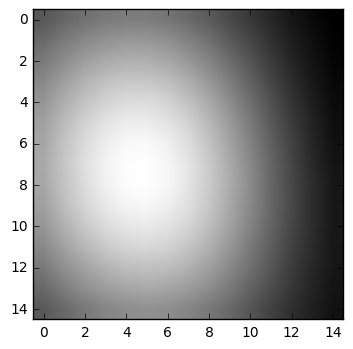

theta: 1.00; psi: 2.44; sigmaX: 0.30; sigmaY: 0.47; freq: 4.15;


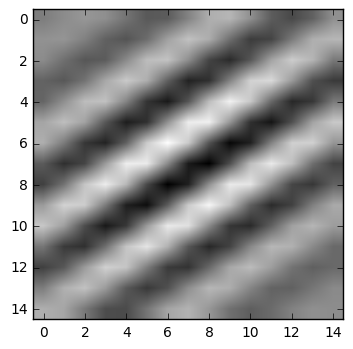

theta: 2.65; psi: 3.15; sigmaX: 0.50; sigmaY: 0.50; freq: 6.77;


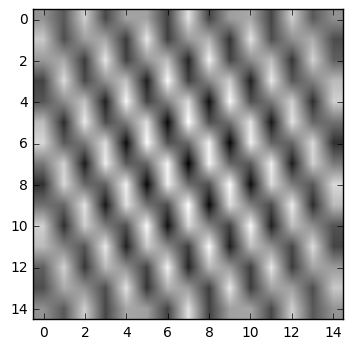

theta: 1.09; psi: 2.88; sigmaX: 0.43; sigmaY: 0.12; freq: 1.48;


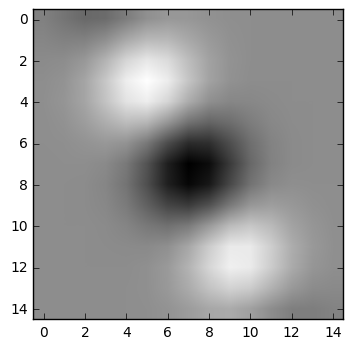

theta: 0.32; psi: 4.88; sigmaX: 0.37; sigmaY: 0.45; freq: 7.46;


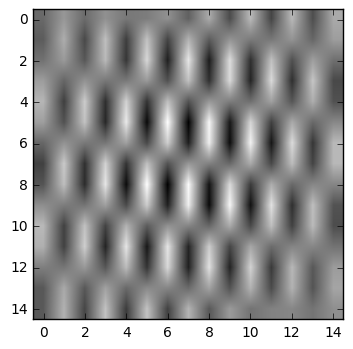

theta: 0.75; psi: 0.05; sigmaX: 0.13; sigmaY: 0.19; freq: 0.40;


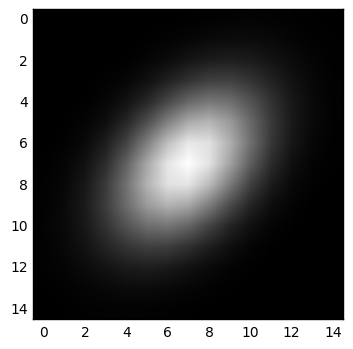

theta: 1.26; psi: 1.06; sigmaX: 0.23; sigmaY: 0.04; freq: 2.95;


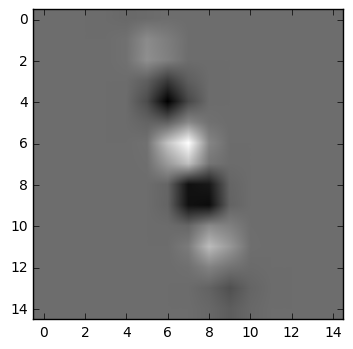

theta: 0.80; psi: 4.17; sigmaX: 0.26; sigmaY: 0.16; freq: 3.93;


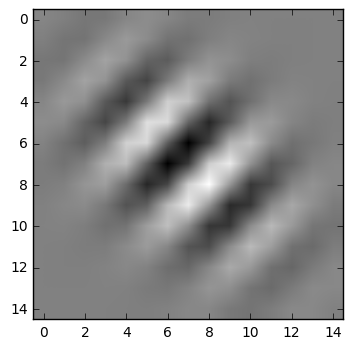

theta: 2.36; psi: 5.56; sigmaX: 0.48; sigmaY: 0.36; freq: 1.51;


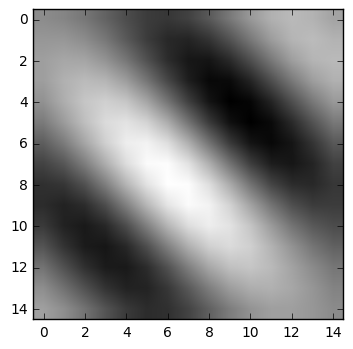

theta: 1.29; psi: 0.82; sigmaX: 0.27; sigmaY: 0.29; freq: 6.37;


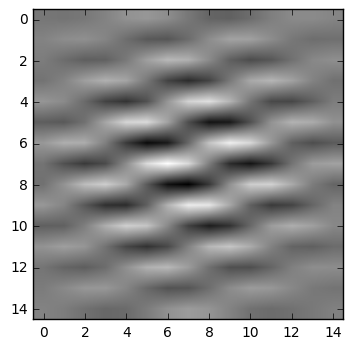

theta: 0.58; psi: 1.02; sigmaX: 0.48; sigmaY: 0.34; freq: 2.29;


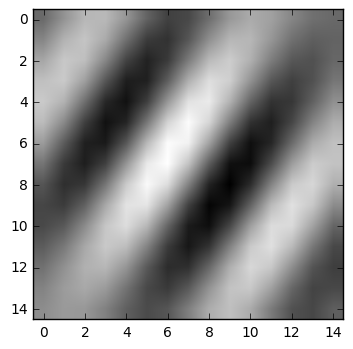

theta: 2.11; psi: 3.62; sigmaX: 0.07; sigmaY: 0.13; freq: 4.72;


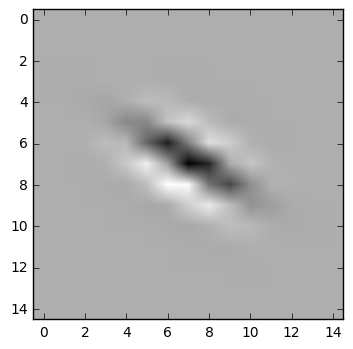

theta: 1.19; psi: 3.90; sigmaX: 0.42; sigmaY: 0.09; freq: 0.72;


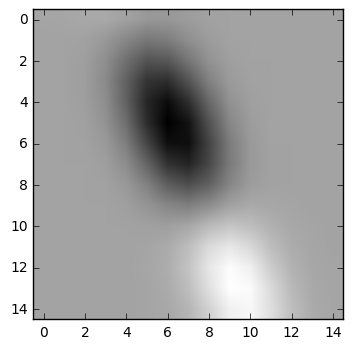

theta: 1.96; psi: 3.06; sigmaX: 0.11; sigmaY: 0.43; freq: 4.05;


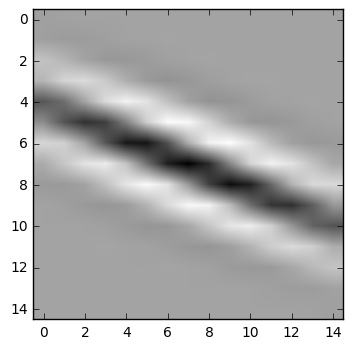

theta: 1.21; psi: 2.02; sigmaX: 0.28; sigmaY: 0.05; freq: 5.69;


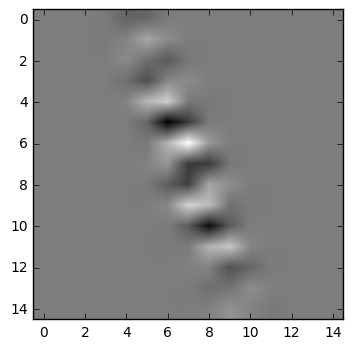

theta: 3.08; psi: 0.89; sigmaX: 0.41; sigmaY: 0.27; freq: 6.50;


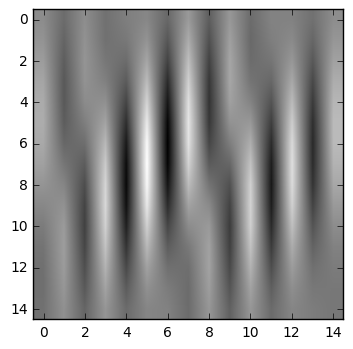

theta: 1.10; psi: 1.57; sigmaX: 0.20; sigmaY: 0.04; freq: 5.70;


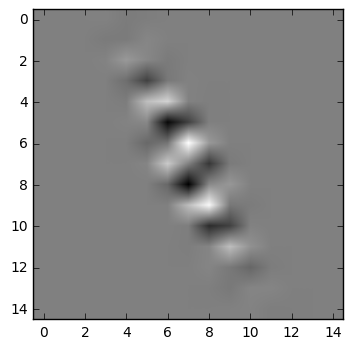

theta: 2.55; psi: 5.78; sigmaX: 0.26; sigmaY: 0.06; freq: 1.28;


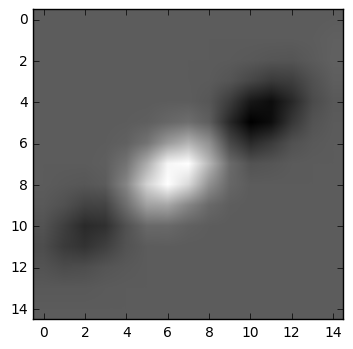

theta: 1.19; psi: 0.43; sigmaX: 0.24; sigmaY: 0.16; freq: 7.04;


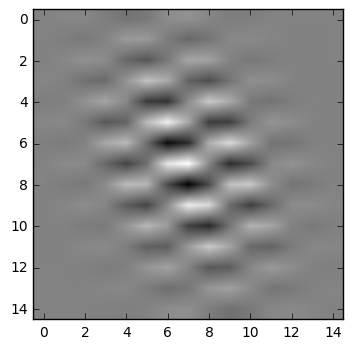

theta: 1.13; psi: 2.71; sigmaX: 0.34; sigmaY: 0.43; freq: 6.56;


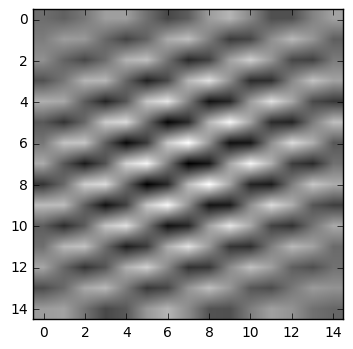

theta: 1.73; psi: 2.94; sigmaX: 0.07; sigmaY: 0.22; freq: 4.12;


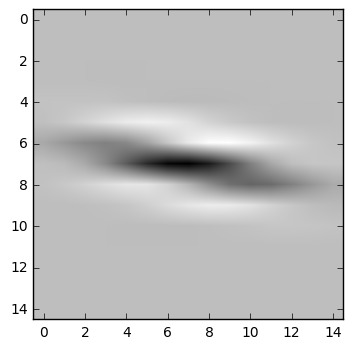

theta: 1.02; psi: 0.60; sigmaX: 0.01; sigmaY: 0.11; freq: 2.54;


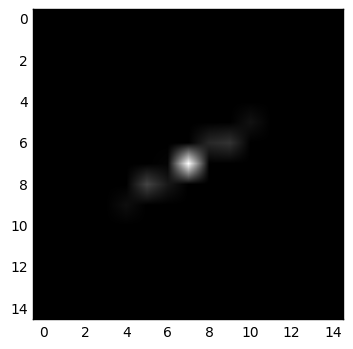

theta: 0.41; psi: 5.17; sigmaX: 0.33; sigmaY: 0.12; freq: 2.56;


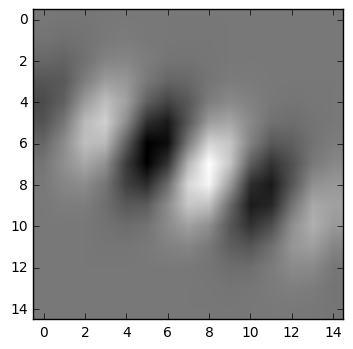

theta: 1.36; psi: 4.62; sigmaX: 0.11; sigmaY: 0.48; freq: 2.95;


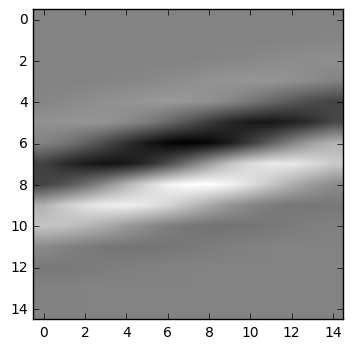

theta: 0.96; psi: 0.74; sigmaX: 0.03; sigmaY: 0.25; freq: 6.36;


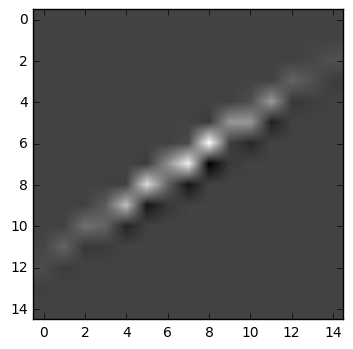

theta: 2.24; psi: 4.19; sigmaX: 0.48; sigmaY: 0.28; freq: 3.28;


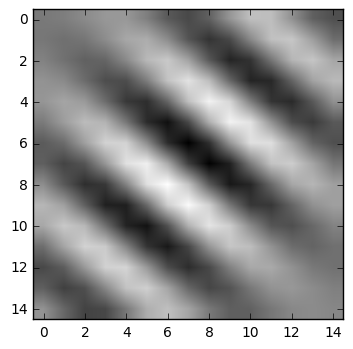

theta: 1.36; psi: 2.24; sigmaX: 0.33; sigmaY: 0.08; freq: 0.83;


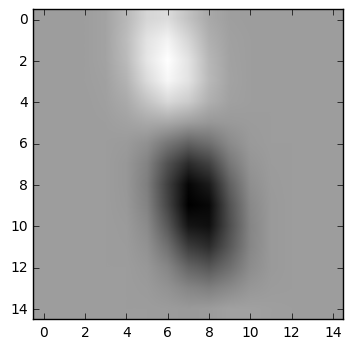

theta: 1.09; psi: 3.35; sigmaX: 0.10; sigmaY: 0.48; freq: 4.64;


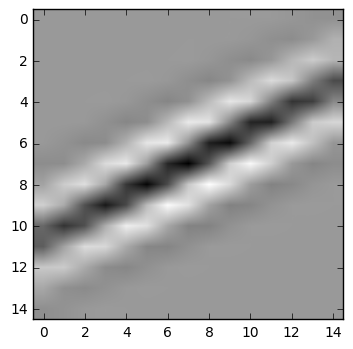

theta: 1.14; psi: 3.12; sigmaX: 0.43; sigmaY: 0.02; freq: 2.55;


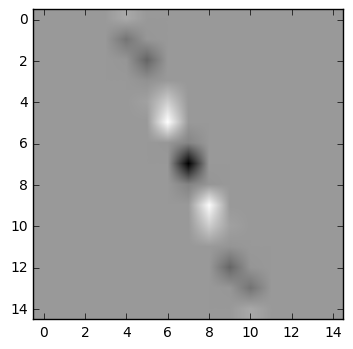

theta: 0.61; psi: 4.36; sigmaX: 0.12; sigmaY: 0.41; freq: 3.99;


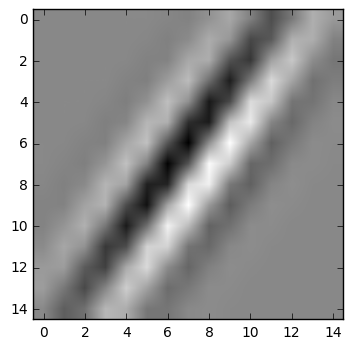

theta: 1.11; psi: 1.65; sigmaX: 0.06; sigmaY: 0.01; freq: 7.18;


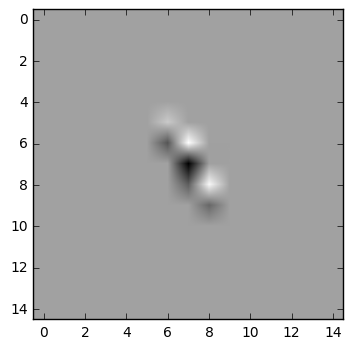

theta: 0.69; psi: 4.05; sigmaX: 0.46; sigmaY: 0.08; freq: 4.98;


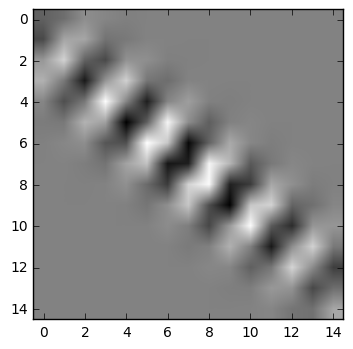

theta: 0.76; psi: 0.29; sigmaX: 0.32; sigmaY: 0.32; freq: 1.33;


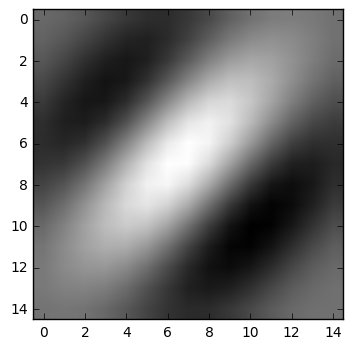

theta: 2.27; psi: 5.83; sigmaX: 0.35; sigmaY: 0.27; freq: 3.03;


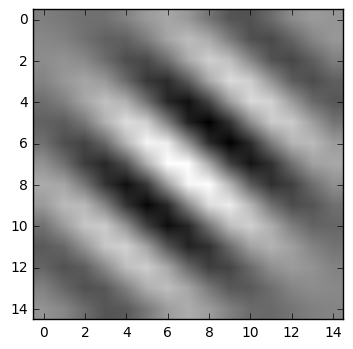

theta: 0.31; psi: 1.63; sigmaX: 0.05; sigmaY: 0.41; freq: 1.99;


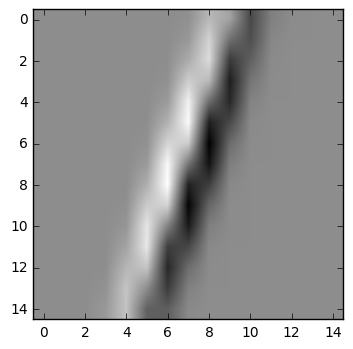

theta: 0.78; psi: 4.61; sigmaX: 0.21; sigmaY: 0.07; freq: 4.32;


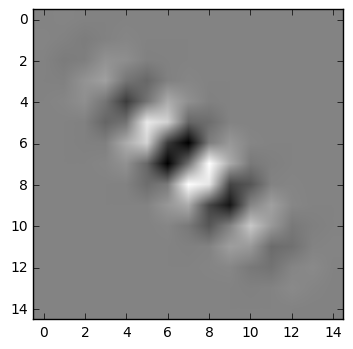

theta: 1.49; psi: 5.08; sigmaX: 0.34; sigmaY: 0.17; freq: 0.52;


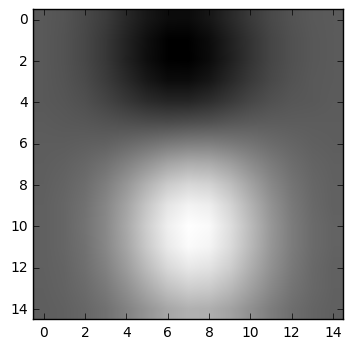

theta: 2.00; psi: 2.73; sigmaX: 0.10; sigmaY: 0.49; freq: 3.42;


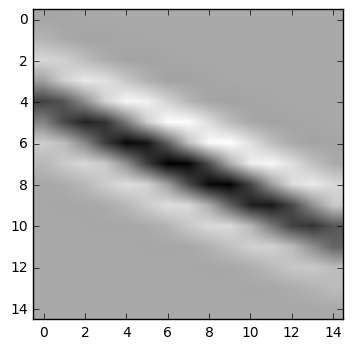

theta: 1.90; psi: 2.02; sigmaX: 0.31; sigmaY: 0.04; freq: 1.34;


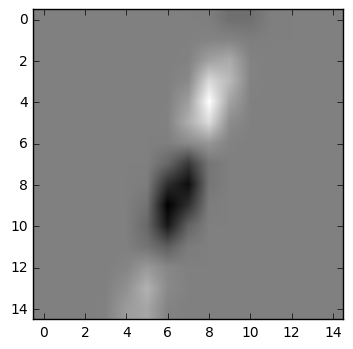

theta: 0.69; psi: 2.16; sigmaX: 0.28; sigmaY: 0.49; freq: 0.73;


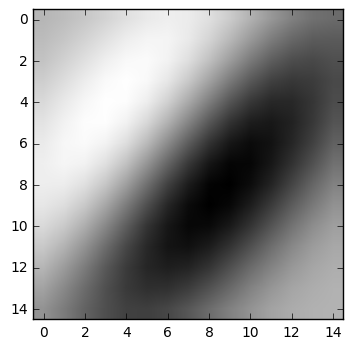

theta: 1.67; psi: 1.96; sigmaX: 0.22; sigmaY: 0.30; freq: 0.43;


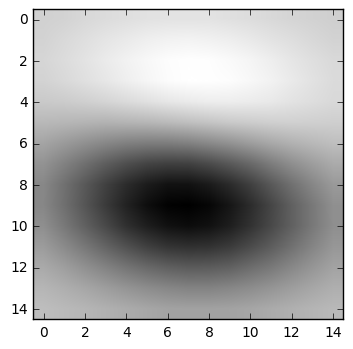

theta: 0.09; psi: 3.40; sigmaX: 0.31; sigmaY: 0.03; freq: 3.13;


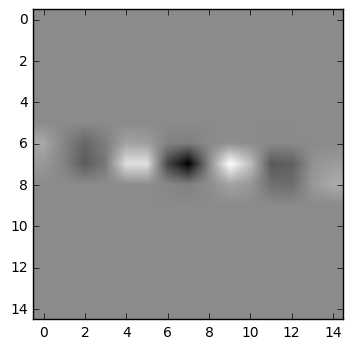

theta: 2.76; psi: 1.65; sigmaX: 0.31; sigmaY: 0.20; freq: 1.76;


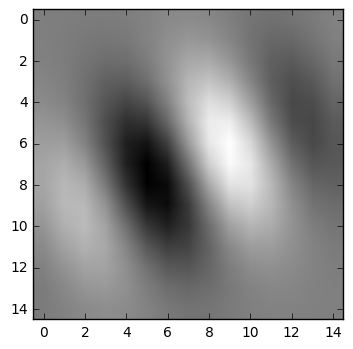

theta: 0.46; psi: 0.42; sigmaX: 0.01; sigmaY: 0.39; freq: 1.23;


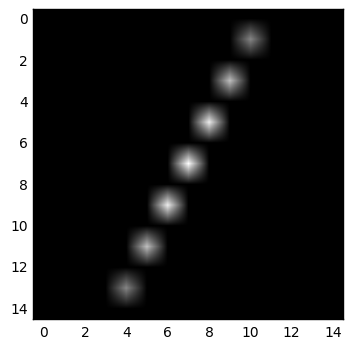

theta: 1.87; psi: 2.20; sigmaX: 0.42; sigmaY: 0.18; freq: 5.95;


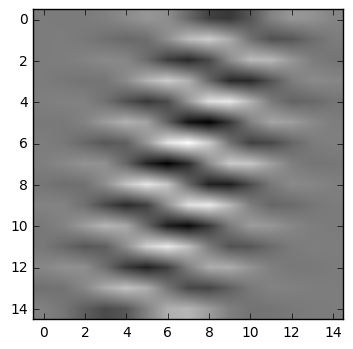

theta: 0.39; psi: 2.83; sigmaX: 0.16; sigmaY: 0.10; freq: 3.95;


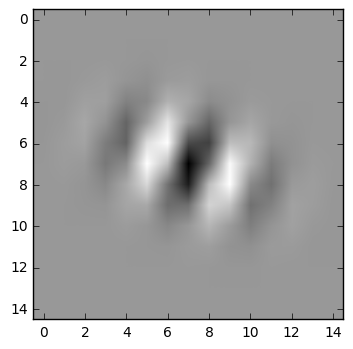

theta: 0.81; psi: 4.81; sigmaX: 0.15; sigmaY: 0.35; freq: 3.29;


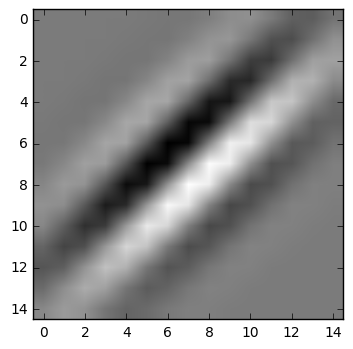

theta: 2.89; psi: 0.97; sigmaX: 0.01; sigmaY: 0.12; freq: 6.55;


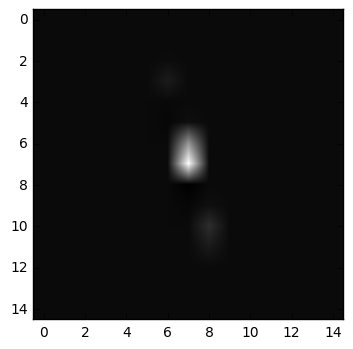

theta: 1.21; psi: 2.11; sigmaX: 0.01; sigmaY: 0.24; freq: 0.25;


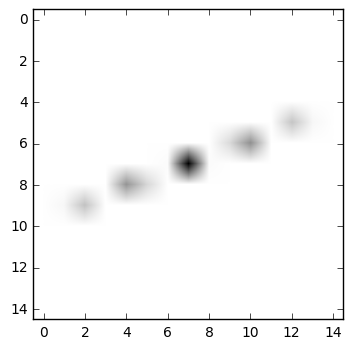

theta: 1.49; psi: 1.19; sigmaX: 0.06; sigmaY: 0.41; freq: 4.80;


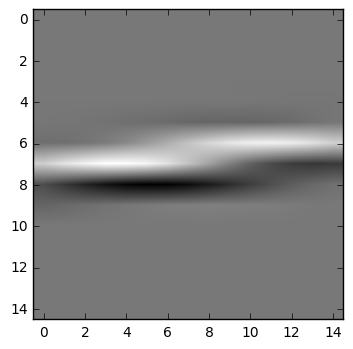

theta: 0.12; psi: 3.52; sigmaX: 0.47; sigmaY: 0.40; freq: 2.97;


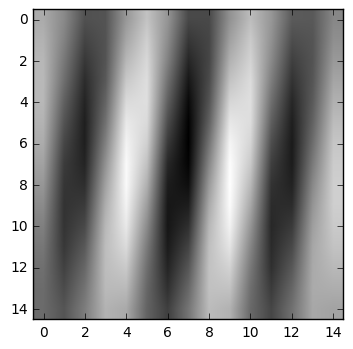

theta: 1.65; psi: 4.26; sigmaX: 0.25; sigmaY: 0.41; freq: 2.61;


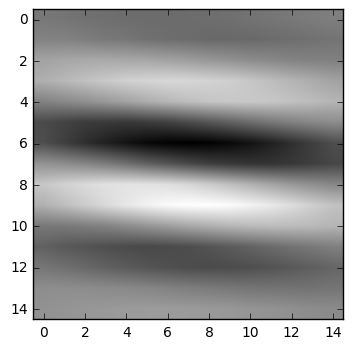

theta: 1.69; psi: 3.12; sigmaX: 0.28; sigmaY: 0.04; freq: 4.70;


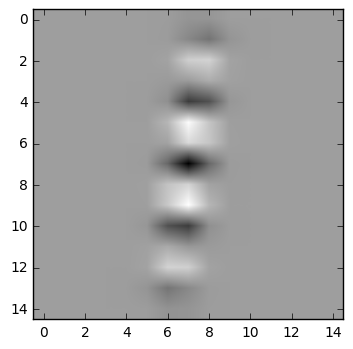

theta: 0.44; psi: 1.23; sigmaX: 0.33; sigmaY: 0.43; freq: 4.10;


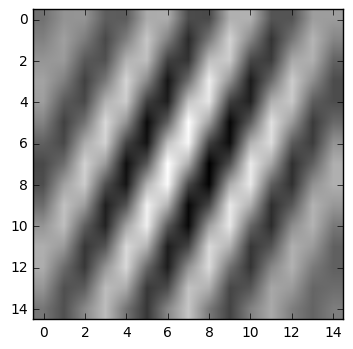

theta: 1.38; psi: 0.04; sigmaX: 0.13; sigmaY: 0.44; freq: 3.70;


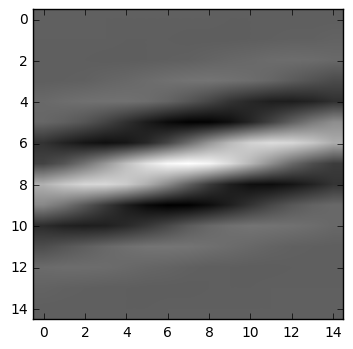

theta: 1.64; psi: 4.85; sigmaX: 0.39; sigmaY: 0.31; freq: 5.12;


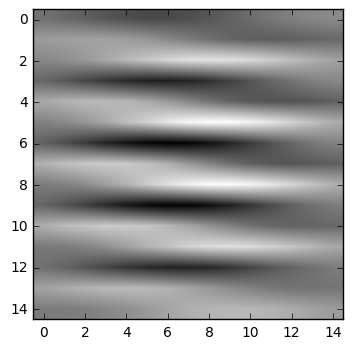

theta: 1.31; psi: 4.30; sigmaX: 0.14; sigmaY: 0.34; freq: 1.91;


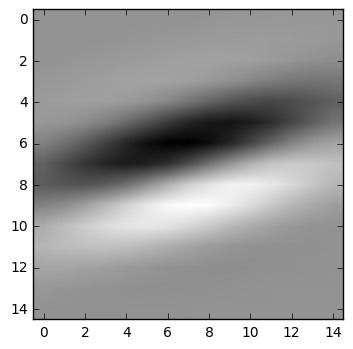

theta: 0.10; psi: 0.29; sigmaX: 0.26; sigmaY: 0.26; freq: 4.83;


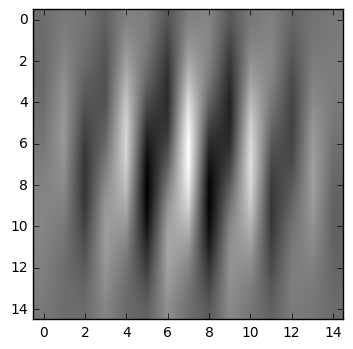

theta: 0.96; psi: 2.61; sigmaX: 0.33; sigmaY: 0.44; freq: 5.45;


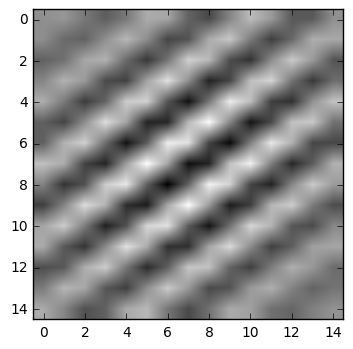

theta: 3.13; psi: 5.56; sigmaX: 0.13; sigmaY: 0.35; freq: 4.11;


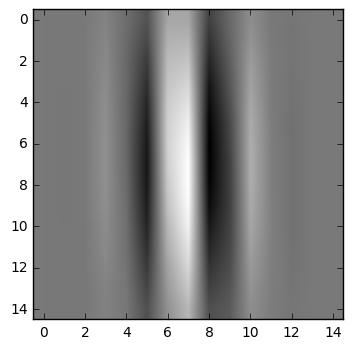

In [19]:
for i in range(net.g1.weight.shape[0]):
    for j in range(net.g1.weight.shape[1]):
        print('theta: {:.2f}; psi: {:.2f}; sigmaX: {:.2f}; sigmaY: {:.2f}; freq: {:.2f};'.format(net.g1.theta[i,j], net.g1.psi[i,j],net.g1.sigma_x[i,j],net.g1.sigma_y[i,j], net.g1.freq[i,j]))
        plt.imshow(net.g1.weight[i,j].to('cpu').detach().numpy(), cmap = 'gray')
        plt.show()

In [20]:
BATCH_SIZE = 16

gabor_test_acc = []

for epoch in range(25):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(int(EMONEW.lenght()/BATCH_SIZE)):
        net.train()
        # get the inputs
        inputs, labels = EMONEW.get_batch(BATCH_SIZE)
        inputs = torch.Tensor(inputs).to(device)/255
        labels = torch.Tensor(labels).max(1)[1].type(torch.LongTensor).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # print statistics
        running_loss += loss.item()
        if i%100 == 99:
            print('[%d] loss: %.3f' %(epoch + 1, running_loss / (100*BATCH_SIZE)))
            running_loss = 0.0
            
        optimizer.step()
        
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i in range(int(EMONEW.lenght(False)/BATCH_SIZE)):
            inputs, labels = EMONEW.get_batch(BATCH_SIZE, False)
            inputs = torch.Tensor(inputs).to(device)/255
            outputs = net(inputs)
            labels = torch.Tensor(labels).max(1)[1].type(torch.LongTensor).to(device)
            test_loss += criterion(outputs, labels) # sum up batch loss
            pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= EMONEW.lenght(False)
    print('\n[{}] Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch+1,
        test_loss, correct, EMONEW.lenght(False),
        100. * correct / EMONEW.lenght(False)))
    gabor_test_acc.append(correct / EMONEW.lenght(False))
print('Finished Training')

[1] loss: 0.124

[1] Test set: Average loss: 0.1198, Accuracy: 192/1095 (18%)

[2] loss: 0.107

[2] Test set: Average loss: 0.0906, Accuracy: 473/1095 (43%)

[3] loss: 0.082

[3] Test set: Average loss: 0.0824, Accuracy: 547/1095 (50%)

[4] loss: 0.074

[4] Test set: Average loss: 0.0763, Accuracy: 577/1095 (53%)

[5] loss: 0.064

[5] Test set: Average loss: 0.0726, Accuracy: 603/1095 (55%)

[6] loss: 0.063

[6] Test set: Average loss: 0.0717, Accuracy: 595/1095 (54%)

[7] loss: 0.055

[7] Test set: Average loss: 0.0709, Accuracy: 636/1095 (58%)

[8] loss: 0.054

[8] Test set: Average loss: 0.0648, Accuracy: 672/1095 (61%)

[9] loss: 0.048

[9] Test set: Average loss: 0.0681, Accuracy: 669/1095 (61%)

[10] loss: 0.046

[10] Test set: Average loss: 0.0639, Accuracy: 707/1095 (65%)

[11] loss: 0.044

[11] Test set: Average loss: 0.0690, Accuracy: 690/1095 (63%)

[12] loss: 0.039

[12] Test set: Average loss: 0.0678, Accuracy: 688/1095 (63%)

[13] loss: 0.038

[13] Test set: Average loss:

theta: 1.40; psi: 2.29; sigmaX: 0.53; sigmaY: 0.30; freq: 4.16;


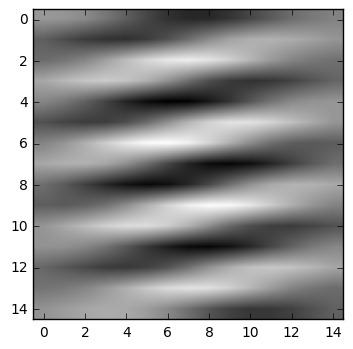

theta: 1.87; psi: 5.27; sigmaX: 0.34; sigmaY: 0.07; freq: 0.49;


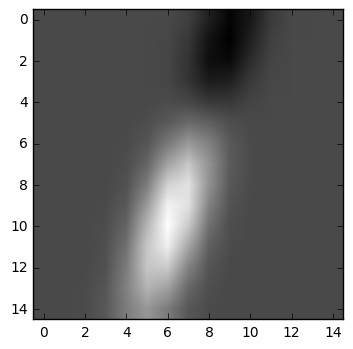

theta: 3.04; psi: 0.10; sigmaX: 0.23; sigmaY: 0.54; freq: 6.06;


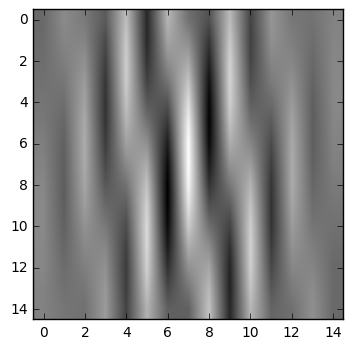

theta: 1.71; psi: 3.77; sigmaX: 0.05; sigmaY: 0.12; freq: 3.63;


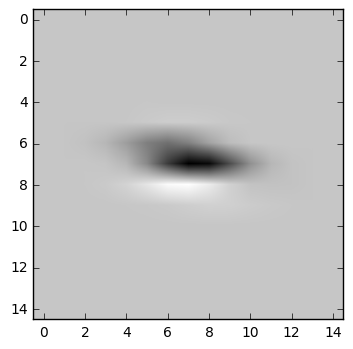

theta: 2.50; psi: 0.36; sigmaX: 0.18; sigmaY: 0.18; freq: 3.01;


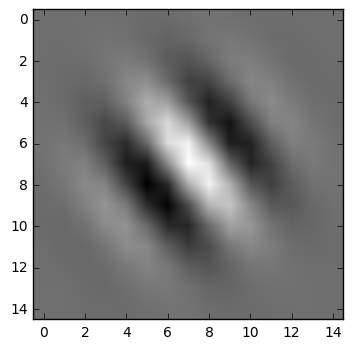

theta: 1.04; psi: 1.36; sigmaX: 0.20; sigmaY: 0.16; freq: 4.59;


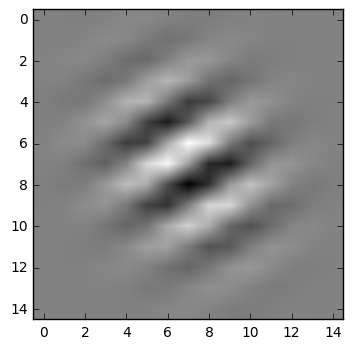

theta: 1.54; psi: 5.13; sigmaX: 0.20; sigmaY: 0.44; freq: 5.93;


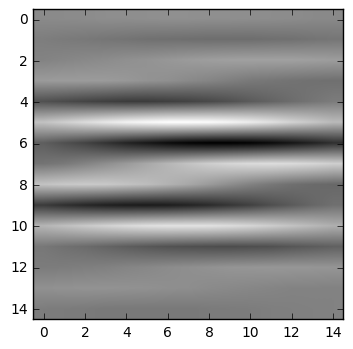

theta: 1.09; psi: 5.04; sigmaX: 0.51; sigmaY: 0.39; freq: 0.73;


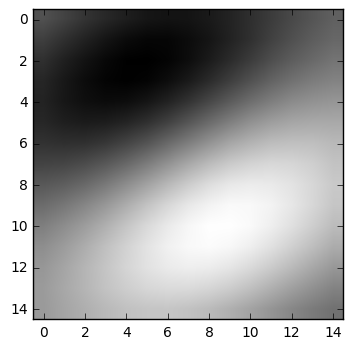

theta: 1.25; psi: 5.74; sigmaX: 0.21; sigmaY: -0.01; freq: 2.39;


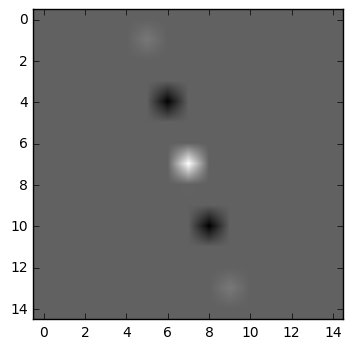

theta: 0.27; psi: 0.99; sigmaX: -0.00; sigmaY: 0.36; freq: 2.24;


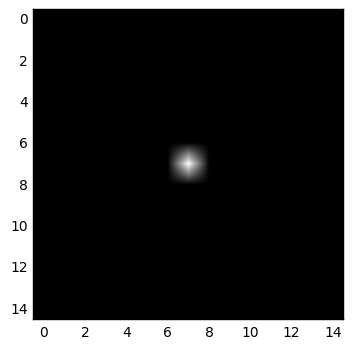

theta: 0.04; psi: 1.74; sigmaX: 0.52; sigmaY: 0.21; freq: 6.80;


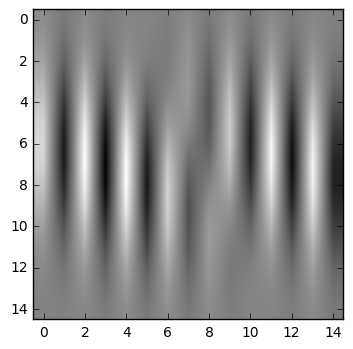

theta: 3.09; psi: 1.73; sigmaX: 0.02; sigmaY: 0.29; freq: 6.14;


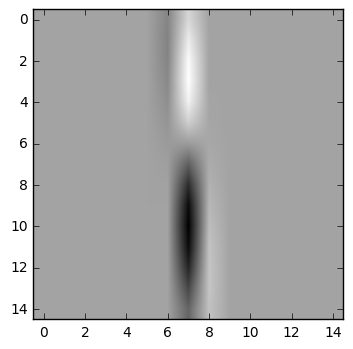

theta: 0.28; psi: 0.59; sigmaX: 0.53; sigmaY: 0.25; freq: 1.86;


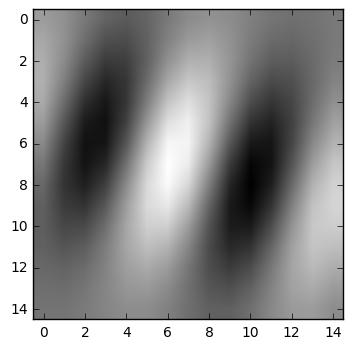

theta: 0.23; psi: 3.45; sigmaX: 0.23; sigmaY: 0.20; freq: 4.77;


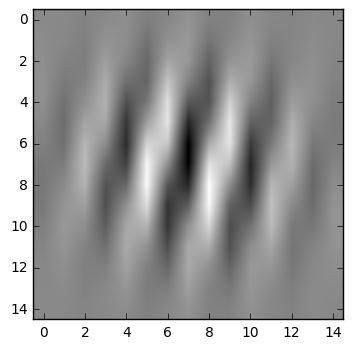

theta: 0.82; psi: 0.24; sigmaX: 0.45; sigmaY: 0.42; freq: 5.98;


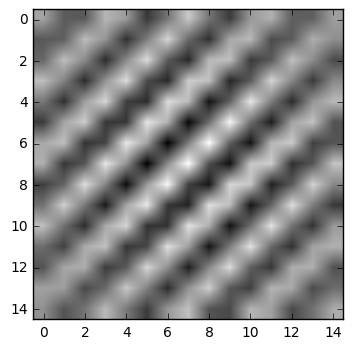

theta: 0.36; psi: 5.96; sigmaX: 0.11; sigmaY: 0.00; freq: 0.67;


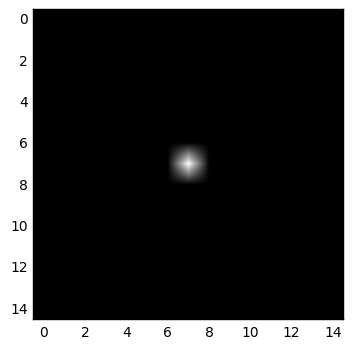

theta: 1.44; psi: 5.97; sigmaX: 0.33; sigmaY: 0.48; freq: 1.27;


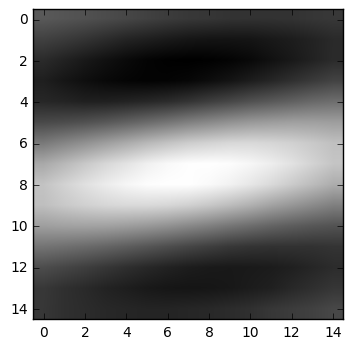

theta: 0.37; psi: 3.26; sigmaX: 0.18; sigmaY: 0.30; freq: 3.10;


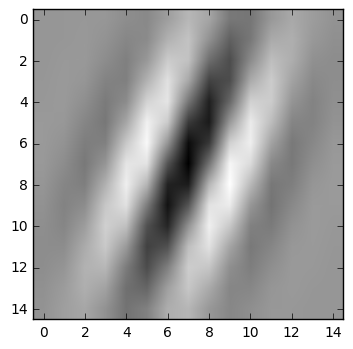

theta: 2.76; psi: 6.24; sigmaX: 0.28; sigmaY: 0.38; freq: 7.35;


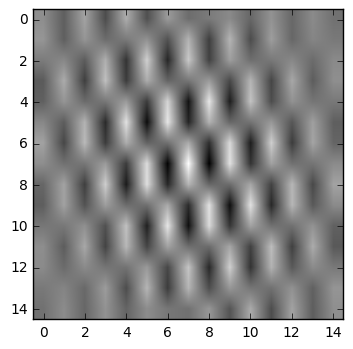

theta: 3.28; psi: 4.89; sigmaX: 0.44; sigmaY: 0.20; freq: 0.87;


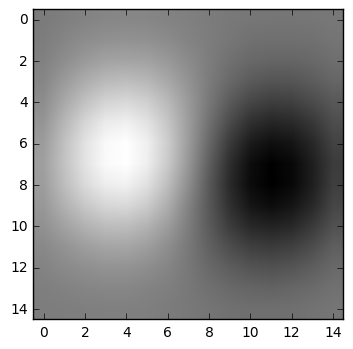

theta: 0.99; psi: 1.77; sigmaX: 0.41; sigmaY: 0.44; freq: 1.05;


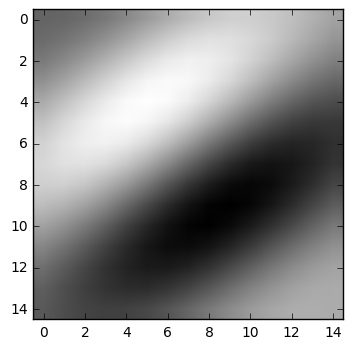

theta: 2.67; psi: 4.16; sigmaX: 0.25; sigmaY: 0.31; freq: 1.67;


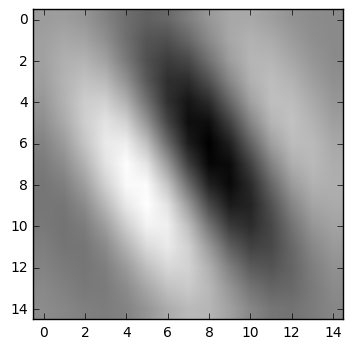

theta: 2.21; psi: 6.07; sigmaX: 0.29; sigmaY: 0.24; freq: 6.23;


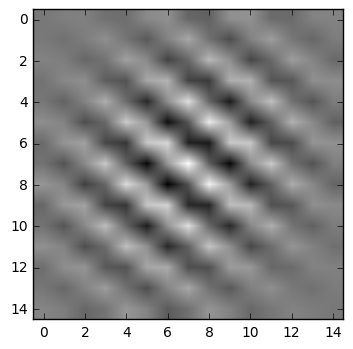

theta: 2.31; psi: 0.74; sigmaX: 0.40; sigmaY: 0.42; freq: 6.15;


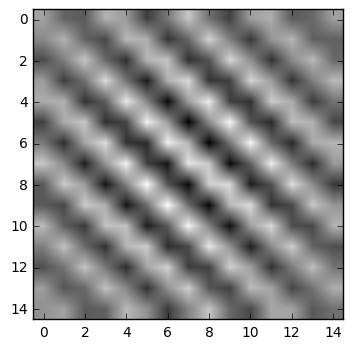

theta: 0.14; psi: 1.88; sigmaX: 0.42; sigmaY: 0.59; freq: 6.78;


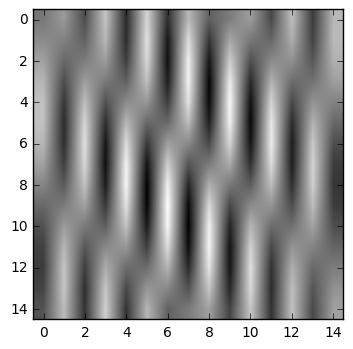

theta: 0.92; psi: 2.00; sigmaX: -0.00; sigmaY: 0.08; freq: 1.21;


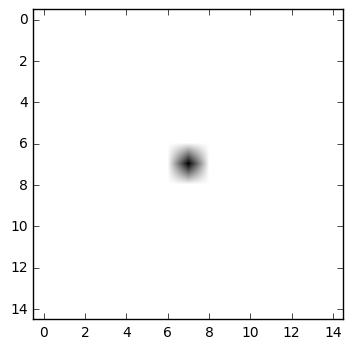

theta: 2.00; psi: 5.35; sigmaX: 0.35; sigmaY: 0.47; freq: 5.87;


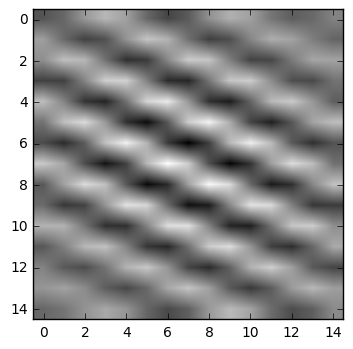

theta: 1.49; psi: 4.05; sigmaX: 0.04; sigmaY: 0.07; freq: 4.11;


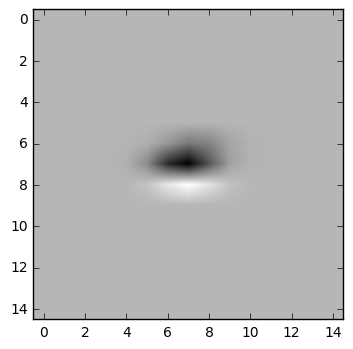

theta: 2.59; psi: 2.89; sigmaX: 0.33; sigmaY: 0.51; freq: 3.64;


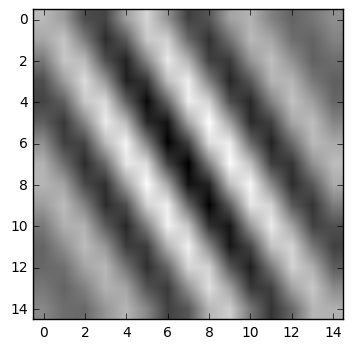

theta: 2.97; psi: 4.11; sigmaX: 0.19; sigmaY: 0.38; freq: 5.55;


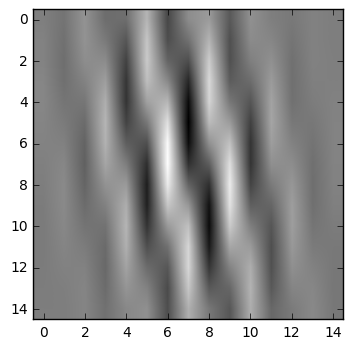

theta: 1.07; psi: 0.32; sigmaX: 0.12; sigmaY: 0.42; freq: 7.46;


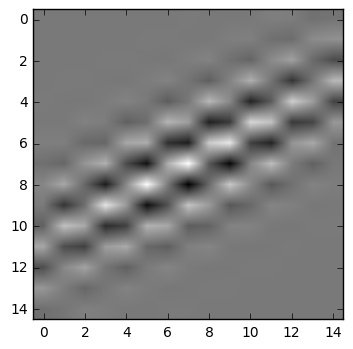

theta: 1.97; psi: 4.12; sigmaX: 0.59; sigmaY: 0.11; freq: 2.26;


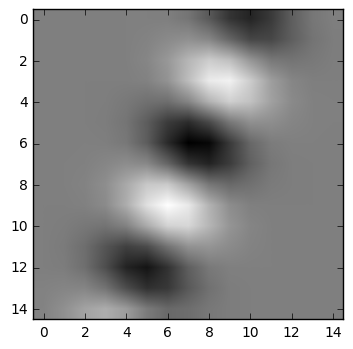

theta: 1.40; psi: 5.68; sigmaX: 0.15; sigmaY: 0.27; freq: 0.55;


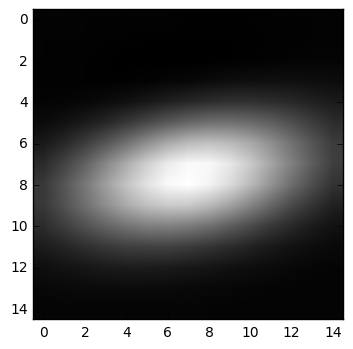

theta: 0.67; psi: 4.65; sigmaX: 0.37; sigmaY: 0.06; freq: 0.85;


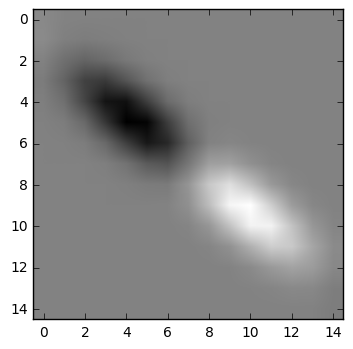

theta: 1.26; psi: 3.82; sigmaX: 0.39; sigmaY: 0.29; freq: 3.65;


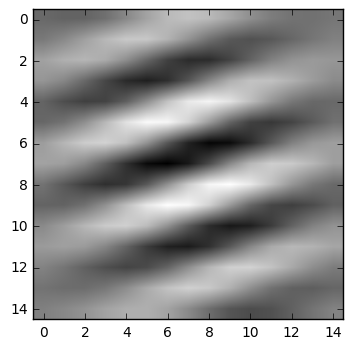

theta: 0.69; psi: 3.47; sigmaX: 0.36; sigmaY: 0.26; freq: 2.75;


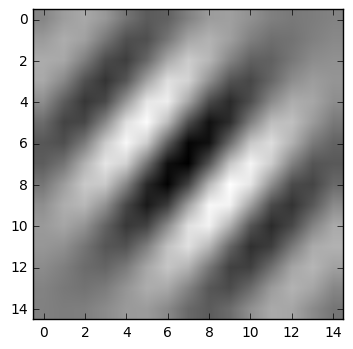

theta: 3.17; psi: 5.24; sigmaX: 0.29; sigmaY: 0.29; freq: 0.39;


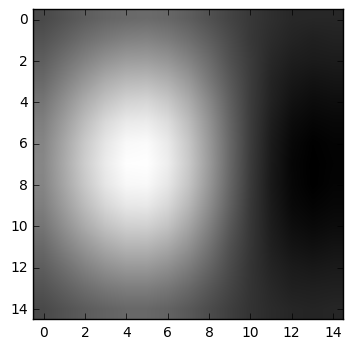

theta: 1.12; psi: 2.41; sigmaX: 0.26; sigmaY: 0.52; freq: 4.16;


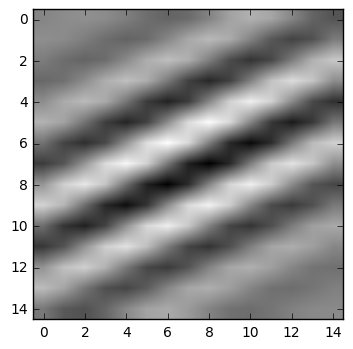

theta: 2.58; psi: 3.07; sigmaX: 0.66; sigmaY: 0.53; freq: 6.61;


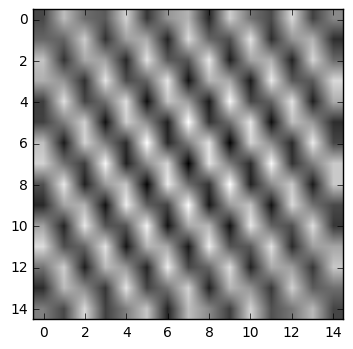

theta: 0.90; psi: 2.87; sigmaX: 0.42; sigmaY: 0.03; freq: 1.70;


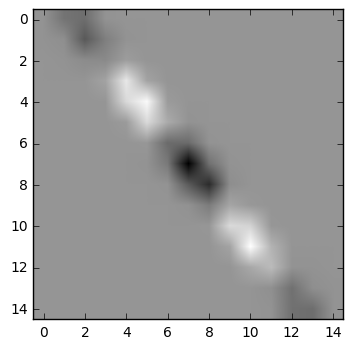

theta: 0.37; psi: 4.88; sigmaX: 0.41; sigmaY: 0.50; freq: 7.49;


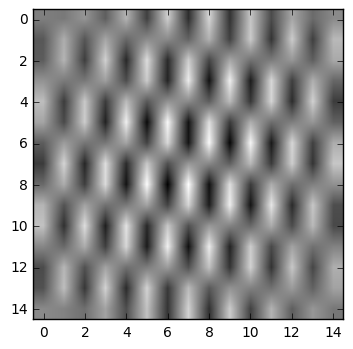

theta: 0.73; psi: 0.13; sigmaX: 0.01; sigmaY: 0.08; freq: 0.46;


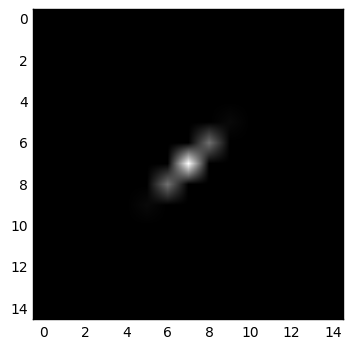

theta: 1.17; psi: 1.17; sigmaX: 0.13; sigmaY: 0.11; freq: 2.84;


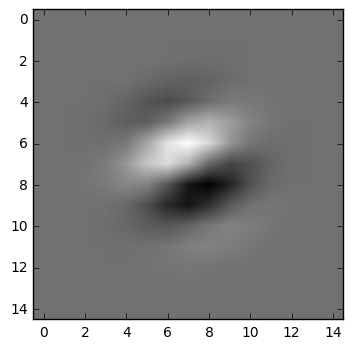

theta: 0.73; psi: 4.20; sigmaX: 0.38; sigmaY: 0.07; freq: 4.05;


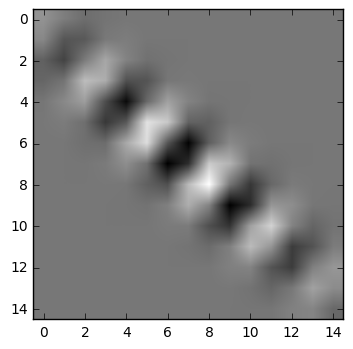

theta: 2.25; psi: 5.57; sigmaX: 0.56; sigmaY: 0.48; freq: 1.58;


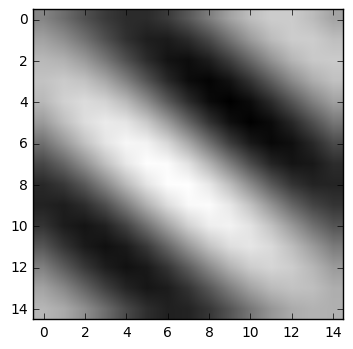

theta: 1.26; psi: 0.71; sigmaX: 0.20; sigmaY: 0.44; freq: 6.40;


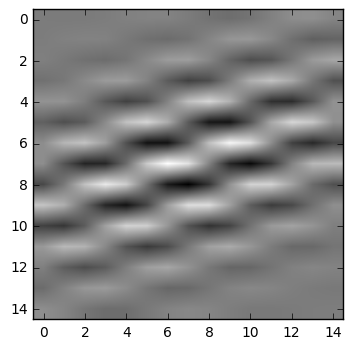

theta: 0.43; psi: 0.69; sigmaX: 0.70; sigmaY: 0.37; freq: 2.16;


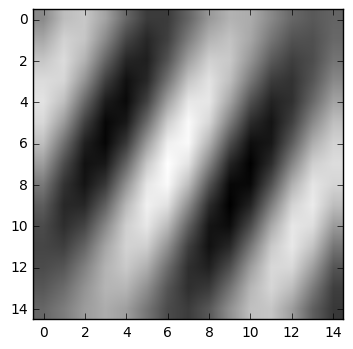

theta: 2.06; psi: 3.56; sigmaX: 0.14; sigmaY: 0.07; freq: 4.71;


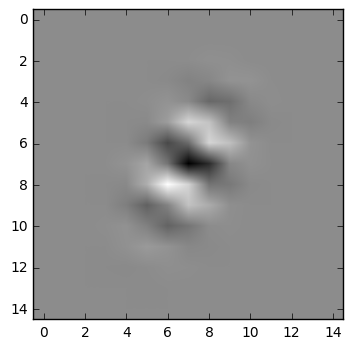

theta: 1.05; psi: 4.06; sigmaX: 0.61; sigmaY: 0.24; freq: 0.89;


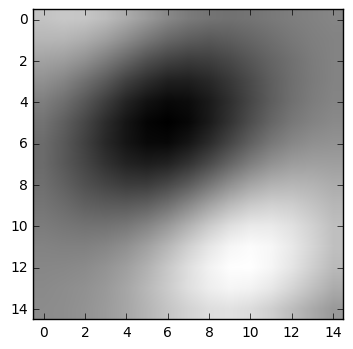

theta: 1.84; psi: 3.04; sigmaX: 0.33; sigmaY: 0.34; freq: 4.15;


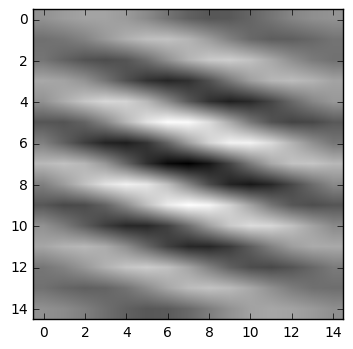

theta: 1.37; psi: 2.08; sigmaX: 0.49; sigmaY: 0.15; freq: 5.64;


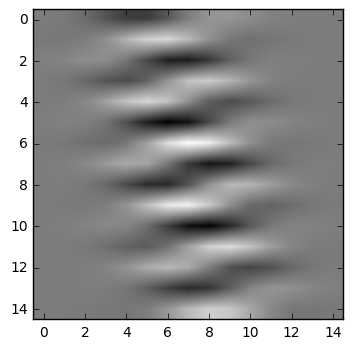

theta: 2.98; psi: 0.98; sigmaX: 0.33; sigmaY: 0.17; freq: 6.63;


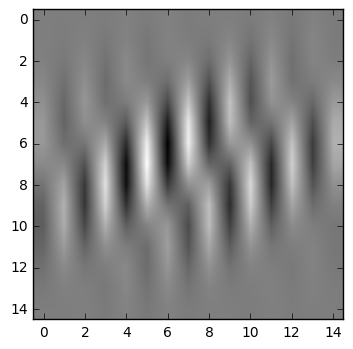

theta: 1.10; psi: 1.57; sigmaX: 0.27; sigmaY: -0.06; freq: 5.57;


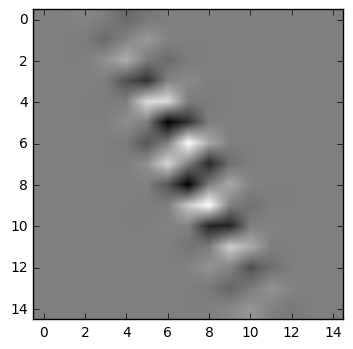

theta: 2.45; psi: 5.63; sigmaX: 0.36; sigmaY: 0.10; freq: 1.32;


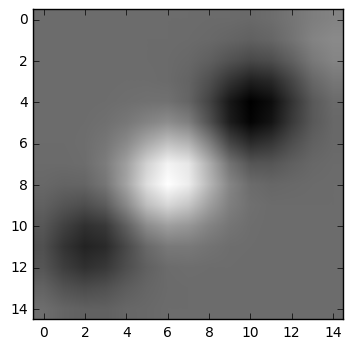

theta: 1.20; psi: 0.63; sigmaX: 0.40; sigmaY: 0.20; freq: 7.12;


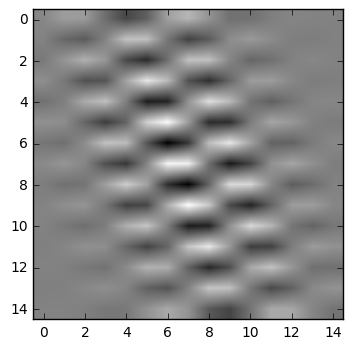

theta: 1.07; psi: 2.55; sigmaX: 0.57; sigmaY: 0.44; freq: 6.69;


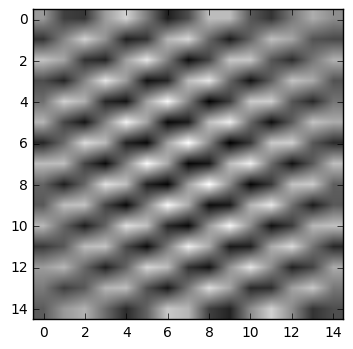

theta: 1.79; psi: 2.99; sigmaX: 0.08; sigmaY: 0.16; freq: 4.08;


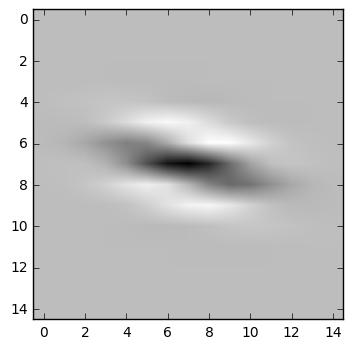

theta: 1.11; psi: 0.64; sigmaX: 0.01; sigmaY: 0.06; freq: 2.55;


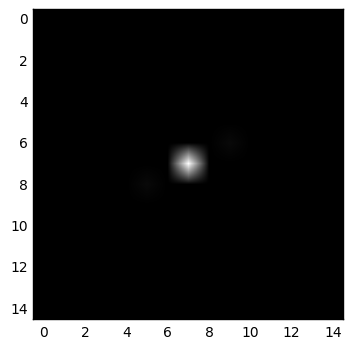

theta: 0.46; psi: 5.17; sigmaX: 0.31; sigmaY: 0.08; freq: 2.69;


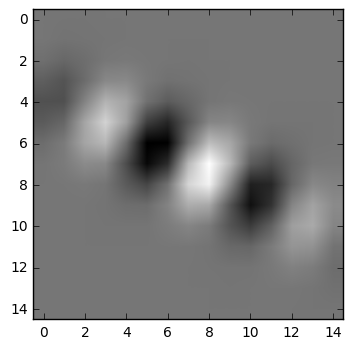

theta: 1.23; psi: 4.59; sigmaX: 0.08; sigmaY: 0.56; freq: 2.89;


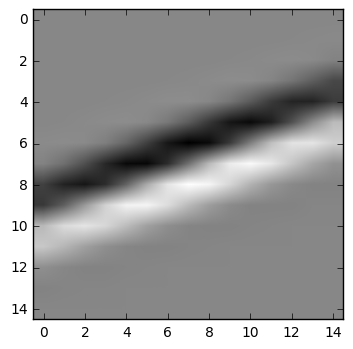

theta: 0.94; psi: 0.73; sigmaX: 0.03; sigmaY: 0.28; freq: 6.32;


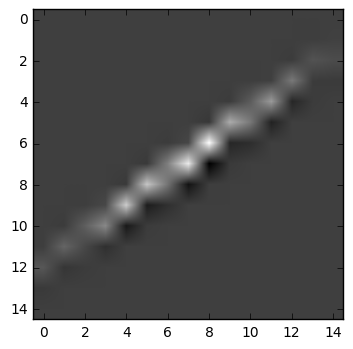

theta: 2.16; psi: 4.35; sigmaX: 0.47; sigmaY: 0.22; freq: 3.26;


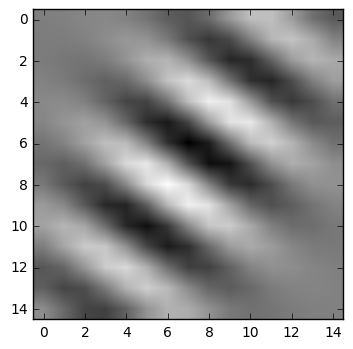

theta: 1.30; psi: 2.28; sigmaX: 0.35; sigmaY: 0.17; freq: 0.79;


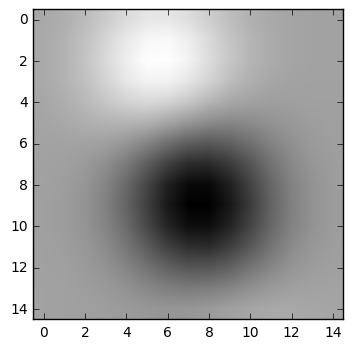

theta: 1.01; psi: 3.22; sigmaX: 0.14; sigmaY: 0.61; freq: 4.31;


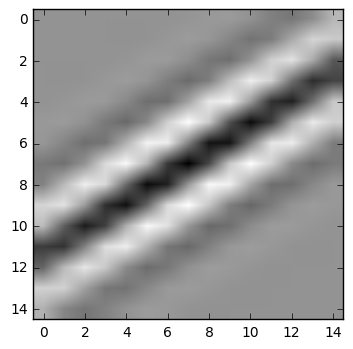

theta: 1.11; psi: 3.40; sigmaX: 0.33; sigmaY: -0.27; freq: 2.55;


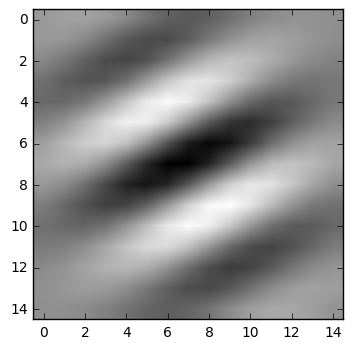

theta: 0.58; psi: 4.27; sigmaX: 0.22; sigmaY: 0.47; freq: 3.90;


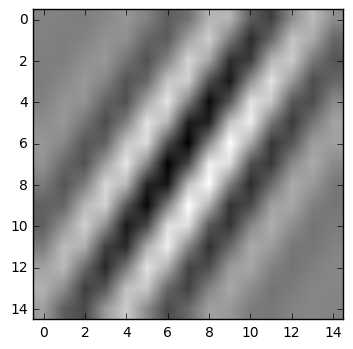

theta: 1.07; psi: 1.61; sigmaX: 0.03; sigmaY: 0.01; freq: 7.21;


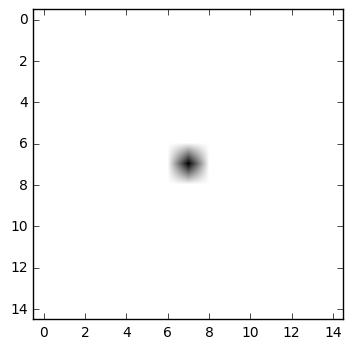

theta: 0.71; psi: 4.09; sigmaX: 0.52; sigmaY: 0.31; freq: 4.92;


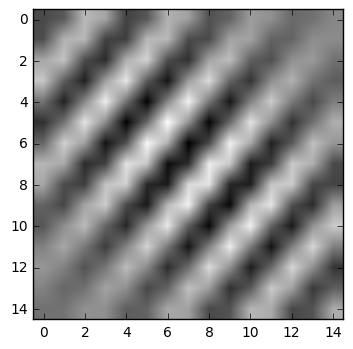

theta: 0.63; psi: 0.10; sigmaX: 0.34; sigmaY: 0.36; freq: 1.33;


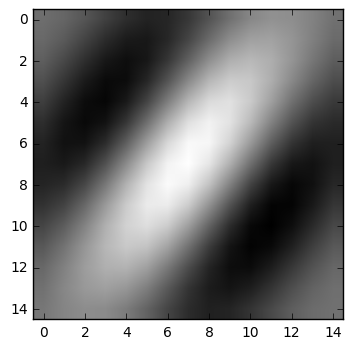

theta: 2.28; psi: 5.57; sigmaX: 0.41; sigmaY: 0.35; freq: 3.05;


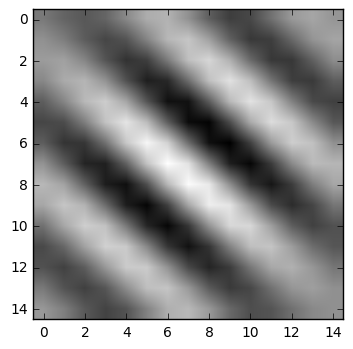

theta: 0.30; psi: 1.59; sigmaX: -0.00; sigmaY: 0.38; freq: 1.96;


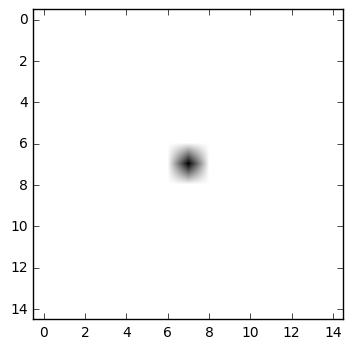

theta: 0.97; psi: 4.55; sigmaX: 0.40; sigmaY: 0.44; freq: 4.12;


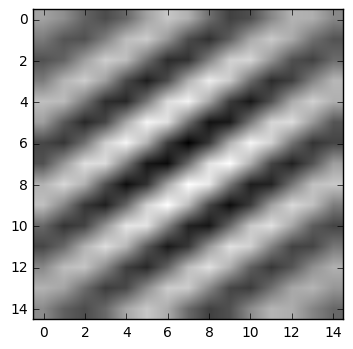

theta: 1.44; psi: 5.07; sigmaX: 0.40; sigmaY: 0.17; freq: 0.56;


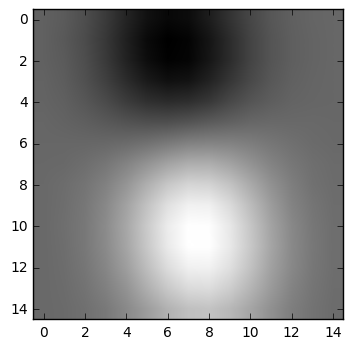

theta: 2.13; psi: 2.71; sigmaX: 0.05; sigmaY: 0.54; freq: 3.36;


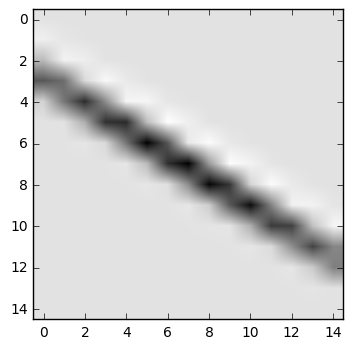

theta: 1.87; psi: 1.85; sigmaX: 0.26; sigmaY: 0.04; freq: 1.46;


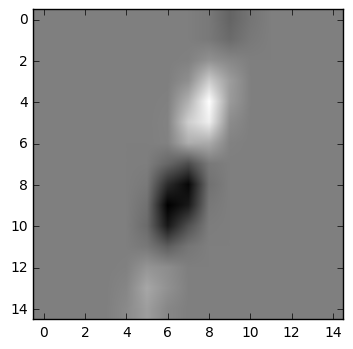

theta: 0.71; psi: 2.15; sigmaX: 0.30; sigmaY: 0.46; freq: 0.73;


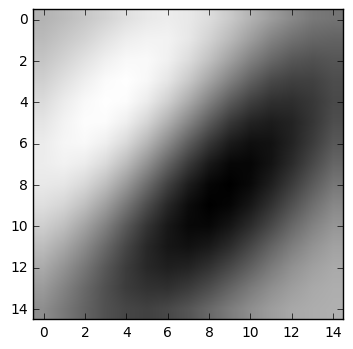

theta: 1.65; psi: 1.97; sigmaX: 0.28; sigmaY: 0.36; freq: 0.46;


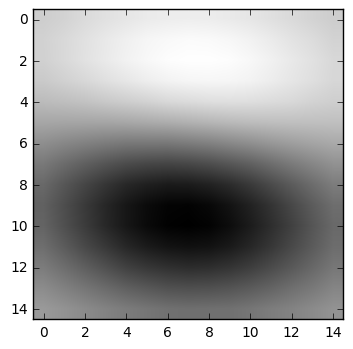

theta: 0.06; psi: 3.36; sigmaX: 0.24; sigmaY: 0.05; freq: 3.08;


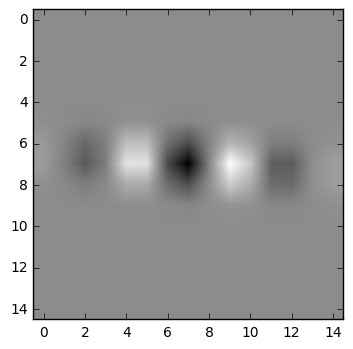

theta: 3.00; psi: 1.65; sigmaX: 0.43; sigmaY: 0.18; freq: 1.83;


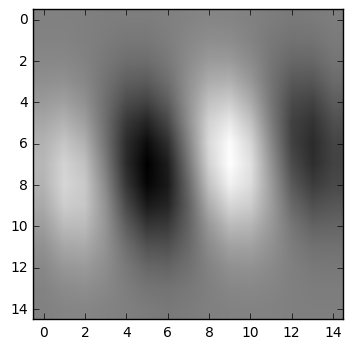

theta: 0.42; psi: 0.47; sigmaX: -0.00; sigmaY: 0.34; freq: 1.28;


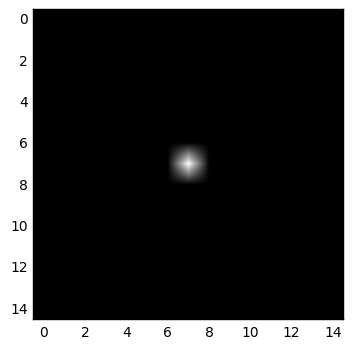

theta: 2.03; psi: 2.11; sigmaX: 0.24; sigmaY: 0.14; freq: 5.90;


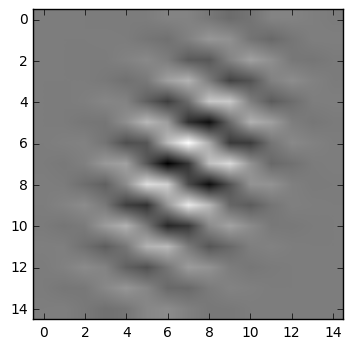

theta: 0.35; psi: 2.72; sigmaX: 0.16; sigmaY: 0.05; freq: 3.98;


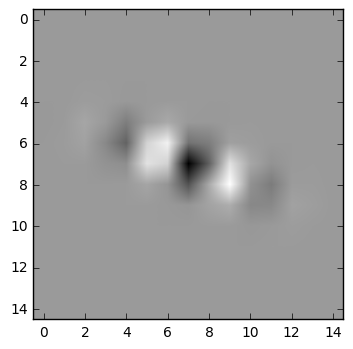

theta: 0.67; psi: 4.84; sigmaX: 0.13; sigmaY: 0.76; freq: 2.90;


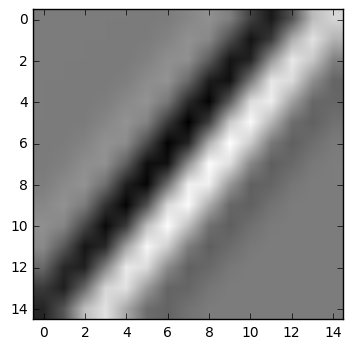

theta: 2.86; psi: 0.87; sigmaX: -0.00; sigmaY: 0.11; freq: 6.56;


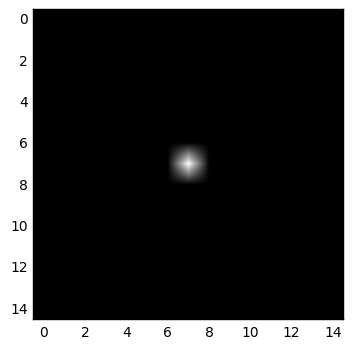

theta: 1.26; psi: 2.06; sigmaX: -0.04; sigmaY: 0.18; freq: 0.06;


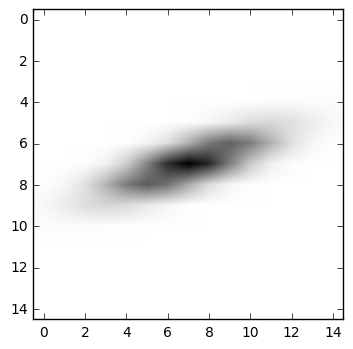

theta: 1.46; psi: 1.19; sigmaX: -0.00; sigmaY: 0.43; freq: 4.81;


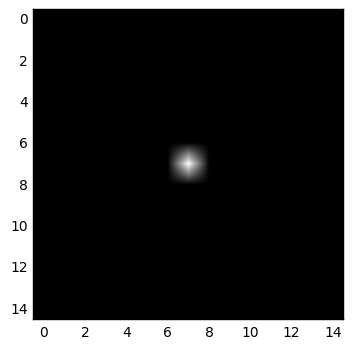

theta: 0.06; psi: 3.71; sigmaX: 0.63; sigmaY: 0.62; freq: 3.09;


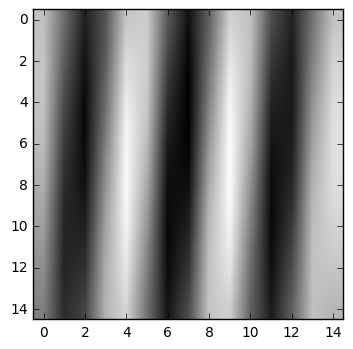

theta: 1.59; psi: 4.43; sigmaX: 0.21; sigmaY: 0.50; freq: 2.51;


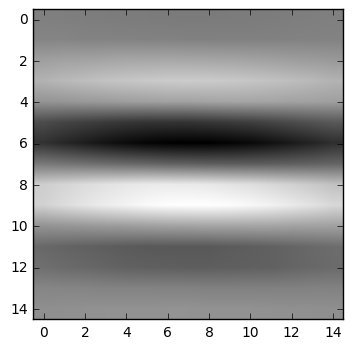

theta: 1.80; psi: 3.07; sigmaX: 0.19; sigmaY: -0.09; freq: 4.88;


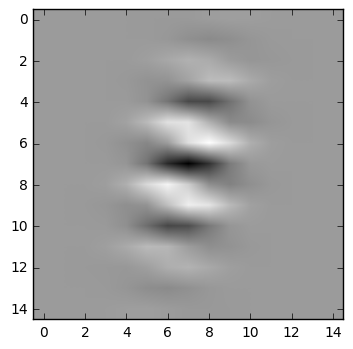

theta: 0.44; psi: 1.09; sigmaX: 0.71; sigmaY: 0.80; freq: 3.90;


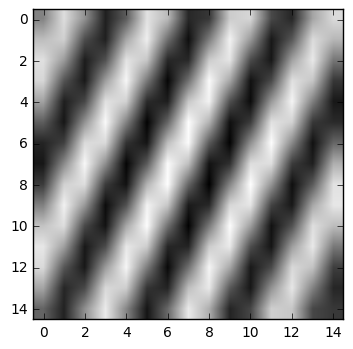

theta: 1.49; psi: -0.13; sigmaX: 0.16; sigmaY: 0.50; freq: 3.69;


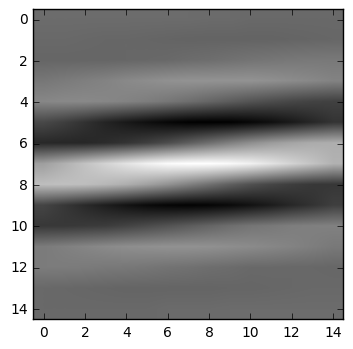

theta: 1.53; psi: 4.87; sigmaX: 0.45; sigmaY: 0.38; freq: 5.06;


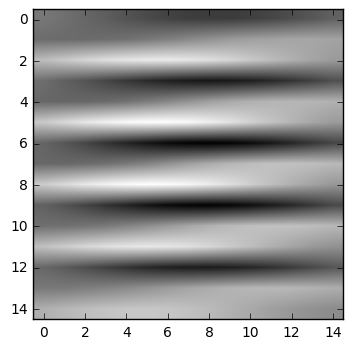

theta: 1.10; psi: 4.35; sigmaX: 0.20; sigmaY: 0.34; freq: 1.99;


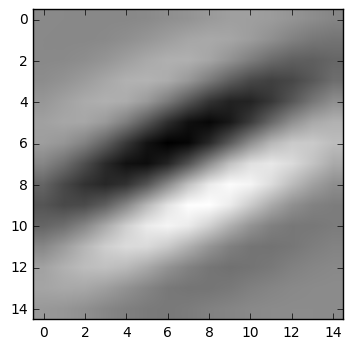

theta: 0.01; psi: 0.46; sigmaX: 0.17; sigmaY: 0.25; freq: 4.88;


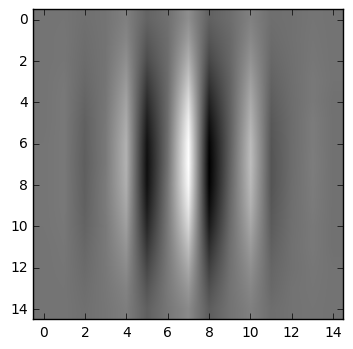

theta: 0.93; psi: 2.45; sigmaX: 0.44; sigmaY: 0.60; freq: 5.44;


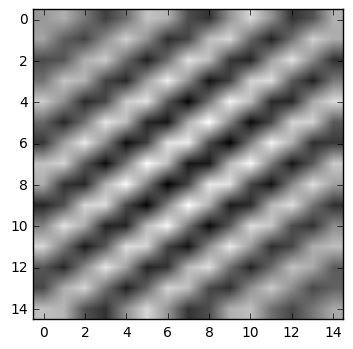

theta: 3.07; psi: 5.41; sigmaX: 0.26; sigmaY: 0.56; freq: 4.08;


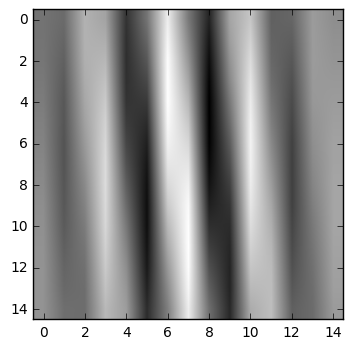

In [21]:
for i in range(net.g1.weight.shape[0]):
    for j in range(net.g1.weight.shape[1]):
        print('theta: {:.2f}; psi: {:.2f}; sigmaX: {:.2f}; sigmaY: {:.2f}; freq: {:.2f};'.format(net.g1.theta[i,j], net.g1.psi[i,j],net.g1.sigma_x[i,j],net.g1.sigma_y[i,j], net.g1.freq[i,j]))
        plt.imshow(net.g1.weight[i,j].to('cpu').detach().numpy(), cmap = 'gray')
        plt.show()

In [ ]:
del outputs
del inputs
torch.cuda.empty_cache()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from time import time

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.c0 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=2)
        self.c1 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=2)
        self.c2 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=2)
        self.fc1 = nn.Linear(64*8*9, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = F.relu(self.c0(x))
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = nn.Dropout2d(p = 0.25)(x)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = nn.Dropout2d(p = 0.25)(x)
        x = x.view(-1, 64*9*8)
        x = F.relu(self.fc1(x))
        x = nn.Dropout()(x)
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
conv = ConvNet().to(device)
print(conv)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv.parameters())

In [ ]:
conv(torch.rand(1,3,309,287, device = device))

In [ ]:
BATCH_SIZE = 64
conv_test_acc = []
for epoch in range(250):  # loop over the dataset multiple times
    running_loss = 0.0
    for i in range(int(EMONEW.lenght()/BATCH_SIZE)):
        # get the inputs
        inputs, labels = EMONEW.get_batch(BATCH_SIZE)
        inputs = torch.Tensor(inputs).to(device)/255
        labels = torch.Tensor(labels).max(1)[1].type(torch.LongTensor).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = conv(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i%200 == 199:
            print('[%d] loss: %.3f' %(epoch + 1, running_loss / (20*BATCH_SIZE)))
            running_loss = 0.0
            
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i in range(int(EMONEW.lenght(False)/BATCH_SIZE)):
            inputs, labels = EMONEW.get_batch(BATCH_SIZE, False)
            inputs = torch.Tensor(inputs).to(device)/255
            outputs = conv(inputs)
            labels = torch.Tensor(labels).max(1)[1].type(torch.LongTensor).to(device)
            test_loss += criterion(outputs, labels) # sum up batch loss
            pred = outputs.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= EMONEW.lenght(False)
    print('\n[{}] Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch+1,
        test_loss, correct, EMONEW.lenght(False),
        100. * correct / EMONEW.lenght(False)))
    conv_test_acc.append(correct / EMONEW.lenght(False))
print('Finished Training')

In [ ]:
del outputs
del inputs
torch.cuda.empty_cache()

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from time import time

EMONEW = DatasetLoader()

batch_size = 64
num_classes = 7
epochs = 30

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(309, 287, 3), strides = (2,2)))
model.add(Conv2D(64, (3, 3), activation='relu', strides = (2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', strides = (2,2)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
start = time()

x_train, y_train = EMONEW.get_batch(EMONEW.lenght())
x_test, y_test = EMONEW.get_batch(EMONEW.lenght(), False)

x_train = x_train / 255
x_test = x_test / 255

model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      validation_data=(x_test, y_test))
    
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(time() - start)

In [ ]:
plt.plot(gabor_test_acc, label = 'gabor')
plt.plot(conv_test_acc, label = 'conv')
plt.legend(loc = 0)
plt.tight_layout()
plt.title('Test accuracy')
plt.show()

In [ ]:
net.g1.weight.shape[0]

In [ ]:
for i in range(net.g1.weight.shape[0]):
    for j in range(net.g1.weight.shape[1]):
        plt.imshow(net.g1.weight[i,j].to('cpu').detach().numpy(), cmap = 'gray', interpolation='none')
        plt.show()

In [ ]:
for i in range(conv.c0.weight.shape[0]):
    for j in range(conv.c0.weight.shape[1]):
        plt.imshow(conv.c0.weight[i,j].to('cpu').detach().numpy(), cmap = 'gray')
        plt.show()

## Test GLayer eval.time

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from numpy.random import rand, randn

In [ ]:
img = cv2.imread('cat.jpg',0)
plt.imshow(img, cmap='Greys')
plt.show()

In [ ]:
img = torch.tensor(img).unsqueeze(0).unsqueeze(0).type(torch.FloatTensor)

In [ ]:
GLayer = MyGabor(1,1, kernel_size=(15,15)).to(device)
CLayer = nn.Conv2d(1,1, kernel_size=(15,15)).to(device)

In [ ]:
%timeit -r 100 x = GLayer(img.to(device))

In [ ]:
%timeit -r 100 x = CLayer(img.to(device))